# 📊 EDA — Cart-to-Purchase Conversion Prediction
## Dataset: `df_processed_fe_optimized_v2.csv`

**Objective**: Exploratory Data Analysis for the feature-engineered dataset (V2) used in the Cart-to-Purchase Conversion Prediction model.

**Dataset Info**:
- ~2.93M rows × 31 columns
- Target: `is_purchased` (binary classification)
- Features: User-level, Product-level, Brand-level aggregates + price comparisons

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

%matplotlib inline

##  **Load Data**

In [4]:
DATA_PATH = "../../../data_pipeline/data/processed/df_processed_fe_optimized_v2.csv"

df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
df.head()

Shape: (2929997, 31)
Memory usage: 1645.8 MB


,user_id,product_id,event_timestamp,created_timestamp,category_code_level1,category_code_level2,brand,event_weekday,price,activity_count,...,product_total_views,product_total_carts,product_total_purchases,product_view_to_cart_rate,product_cart_to_purchase_rate,product_unique_buyers,brand_purchase_rate,price_vs_user_avg,price_vs_category_avg,is_purchased
0,94566147,1005007,2019-11-12 15:04:08,2026-01-18 22:17:22.150556,electronics,smartphone,xiaomi,1,93.78,3,...,26505,2589,654,0.097680,0.252607,548,0.262642,1.0,0.221107,0
1,176495092,6301929,2019-11-08 14:01:42,2026-01-18 22:17:22.150556,appliances,kitchen,polaris,4,28.31,3,...,144,3,1,0.020833,0.333333,1,0.303095,1.0,0.120976,0
2,239198635,1003942,2019-11-09 15:29:59,2026-01-18 22:17:22.150556,electronics,smartphone,xiaomi,5,187.24,3,...,6618,84,22,0.012693,0.261905,19,0.262642,1.0,0.441459,0
3,239198635,1003942,2019-11-09 15:30:54,2026-01-18 22:17:22.150556,electronics,smartphone,xiaomi,5,187.24,5,...,6618,84,22,0.012693,0.261905,19,0.262642,1.0,0.441459,0
4,269003139,6000032,2019-11-26 14:38:48,2026-01-18 22:17:22.150556,auto,accessories,cenmax,1,66.39,12,...,9319,291,84,0.031227,0.288660,72,0.291525,1.0,0.443217,0


---
# Phase 1: Data Overview & Quality

### 1.1 Target Distribution

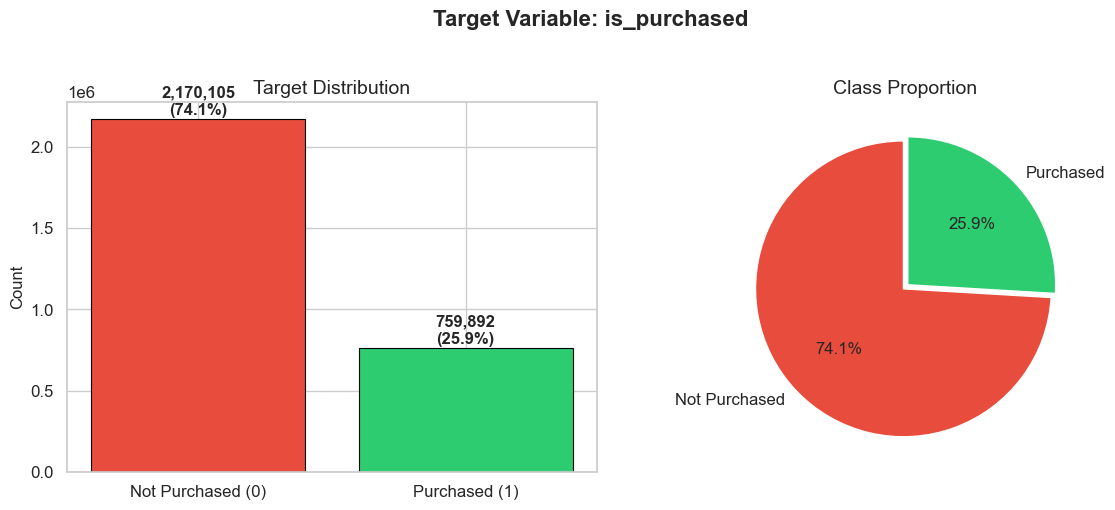

Imbalance ratio: 1:2.86 (negative:positive)


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
target_counts = df["is_purchased"].value_counts()
bars = axes[0].bar(
    ["Not Purchased (0)", "Purchased (1)"],
    target_counts.values,
    color=["#e74c3c", "#2ecc71"],
    edgecolor="black",
    linewidth=0.8,
)
for bar, count in zip(bars, target_counts.values):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10000,
        f"{count:,}\n({count / len(df) * 100:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )
axes[0].set_title("Target Distribution")
axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(
    target_counts.values,
    labels=["Not Purchased", "Purchased"],
    autopct="%1.1f%%",
    colors=["#e74c3c", "#2ecc71"],
    startangle=90,
    explode=(0.02, 0.02),
    textprops={"fontsize": 12},
)
axes[1].set_title("Class Proportion")

plt.suptitle("Target Variable: is_purchased", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print(f"Imbalance ratio: 1:{target_counts[0] / target_counts[1]:.2f} (negative:positive)")

### 1.2 Data Types & Info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929997 entries, 0 to 2929996
Data columns (total 31 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   user_id                        int64  
 1   product_id                     int64  
 2   event_timestamp                object 
 3   created_timestamp              object 
 4   category_code_level1           object 
 5   category_code_level2           object 
 6   brand                          object 
 7   event_weekday                  int64  
 8   price                          float64
 9   activity_count                 int64  
 10  event_hour                     int64  
 11  user_total_events              int64  
 12  user_total_views               int64  
 13  user_total_carts               int64  
 14  user_total_purchases           int64  
 15  user_view_to_cart_rate         float64
 16  user_cart_to_purchase_rate     float64
 17  user_avg_purchase_price        float64
 18  us

### 1.3 Missing Values

In [8]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"Missing Count": missing, "Missing %": missing_pct})
missing_df = missing_df[missing_df["Missing Count"] > 0].sort_values("Missing %", ascending=False)

if len(missing_df) == 0:
    print("No missing values found in the dataset!")
else:
    print(f"{len(missing_df)} columns with missing values:")
    display(missing_df)

    fig, ax = plt.subplots(figsize=(12, max(4, len(missing_df) * 0.5)))
    ax.barh(missing_df.index, missing_df["Missing %"], color="#e74c3c")
    ax.set_xlabel("Missing %")
    ax.set_title("Missing Values by Column")
    plt.tight_layout()
    plt.show()

No missing values found in the dataset!


### 1.4 Descriptive Statistics

In [9]:
df.describe().T.style.format("{:.2f}").background_gradient(cmap="YlOrRd", axis=0)

,count,mean,std,min,25%,50%,75%,max
user_id,2929997.00,540843155.72,22728387.14,74383042.00,517672107.00,539944145.00,563634415.00,579967711.00
product_id,2929997.00,8459733.97,13781969.87,1000978.00,1005100.00,3600163.00,12703017.00,100028203.00
event_weekday,2929997.00,3.78,1.89,0.00,3.00,4.00,5.00,6.00
price,2929997.00,290.40,335.70,0.00,74.39,168.70,349.64,2574.07
activity_count,2929997.00,8.28,11.48,1.00,2.00,5.00,9.00,418.00
event_hour,2929997.00,13.83,6.63,0.00,11.00,15.00,19.00,23.00
user_total_events,2929997.00,98.08,143.49,1.00,23.00,53.00,117.00,22929.00
user_total_views,2929997.00,82.71,128.16,0.00,17.00,43.00,98.00,22926.00
user_total_carts,2929997.00,11.71,22.86,1.00,3.00,6.00,12.00,719.00
user_total_purchases,2929997.00,3.66,12.32,0.00,0.00,1.00,3.00,519.00


In [10]:
df.describe(include="object").T

,count,unique,top,freq
event_timestamp,2929997,1227503,2019-11-15 01:01:56,37
created_timestamp,2929997,1,2026-01-18 22:17:22.150556,2929997
category_code_level1,2929997,14,electronics,1473816
category_code_level2,2929997,58,smartphone,1119378
brand,2929997,3058,samsung,572279


---
# Phase 2: Univariate Analysis — Numerical Features

### 2.1 Price Distribution

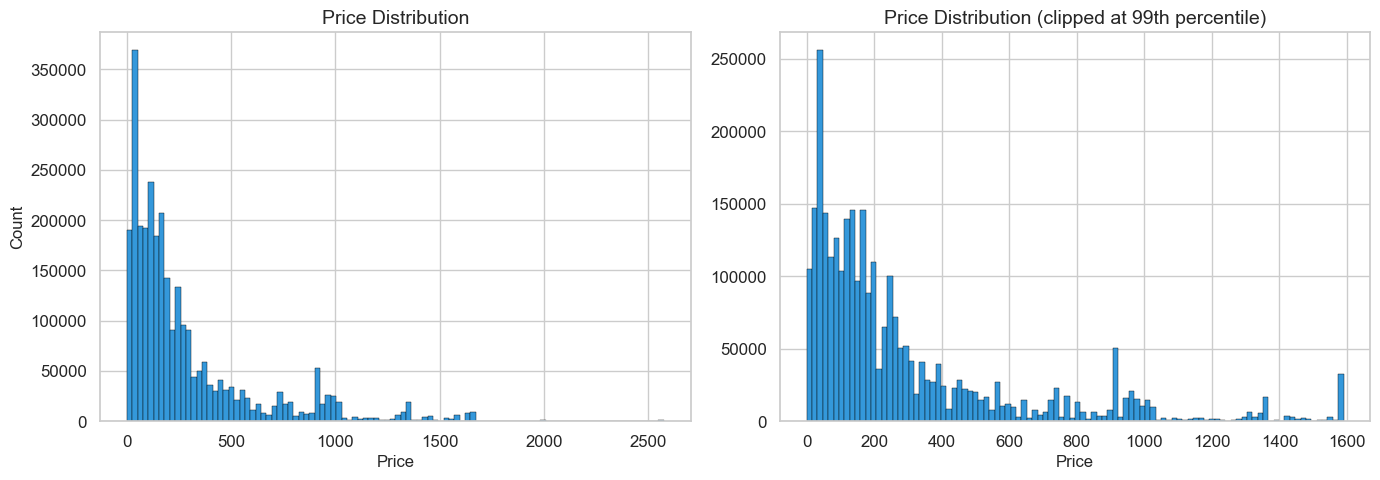

Price stats: mean=290.40, median=168.70, std=335.70, max=2574.07


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["price"], bins=100, color="#3498db", edgecolor="black", linewidth=0.3)
axes[0].set_title("Price Distribution")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Count")

axes[1].hist(
    df["price"].clip(upper=df["price"].quantile(0.99)),
    bins=100,
    color="#3498db",
    edgecolor="black",
    linewidth=0.3,
)
axes[1].set_title("Price Distribution (clipped at 99th percentile)")
axes[1].set_xlabel("Price")

plt.tight_layout()
plt.show()

print(f"Price stats: mean={df['price'].mean():.2f}, median={df['price'].median():.2f}, "
      f"std={df['price'].std():.2f}, max={df['price'].max():.2f}")

### 2.2 Activity Count Distribution

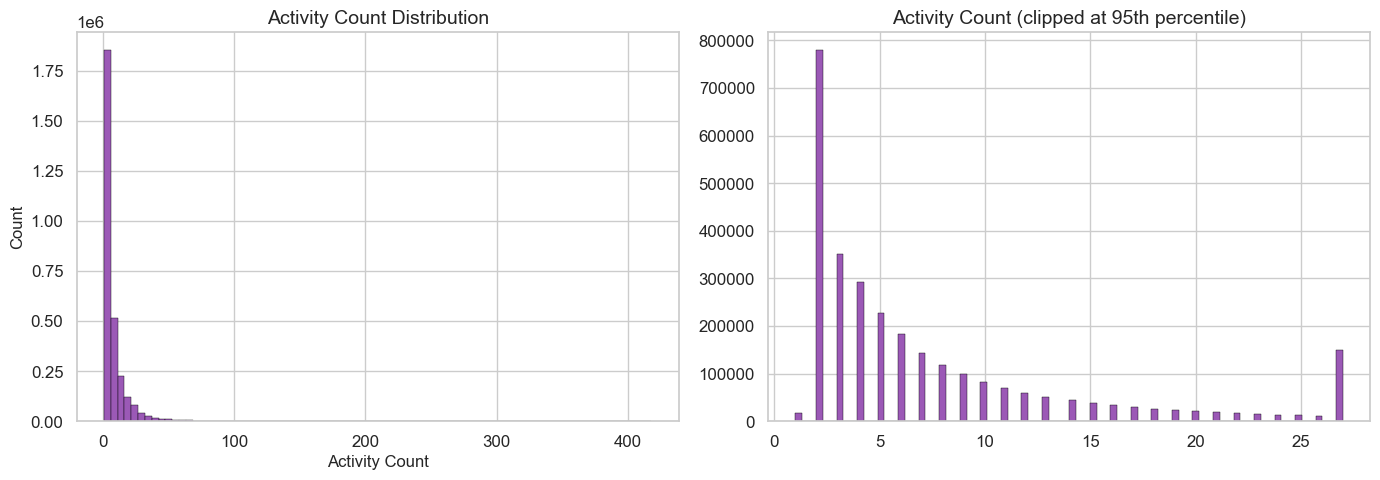

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["activity_count"], bins=80, color="#9b59b6", edgecolor="black", linewidth=0.3)
axes[0].set_title("Activity Count Distribution")
axes[0].set_xlabel("Activity Count")
axes[0].set_ylabel("Count")

axes[1].hist(
    df["activity_count"].clip(upper=df["activity_count"].quantile(0.95)),
    bins=80,
    color="#9b59b6",
    edgecolor="black",
    linewidth=0.3,
)
axes[1].set_title("Activity Count (clipped at 95th percentile)")

plt.tight_layout()
plt.show()

### 2.3 Event Hour Distribution

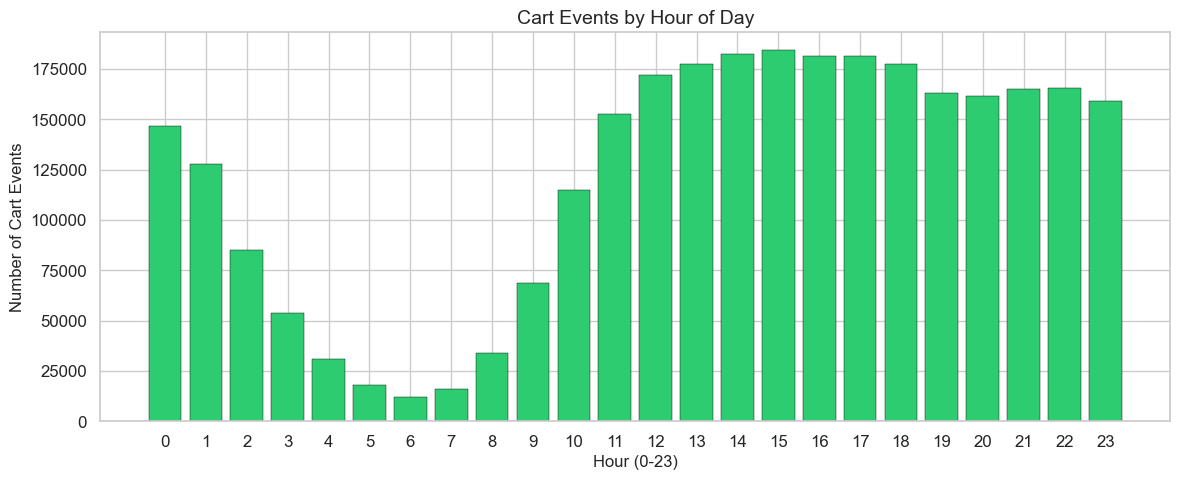

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
hour_counts = df["event_hour"].value_counts().sort_index()
bars = ax.bar(hour_counts.index, hour_counts.values, color="#2ecc71", edgecolor="black", linewidth=0.3)
ax.set_title("Cart Events by Hour of Day")
ax.set_xlabel("Hour (0-23)")
ax.set_ylabel("Number of Cart Events")
ax.set_xticks(range(24))
plt.tight_layout()
plt.show()

### 2.4 Event Weekday Distribution

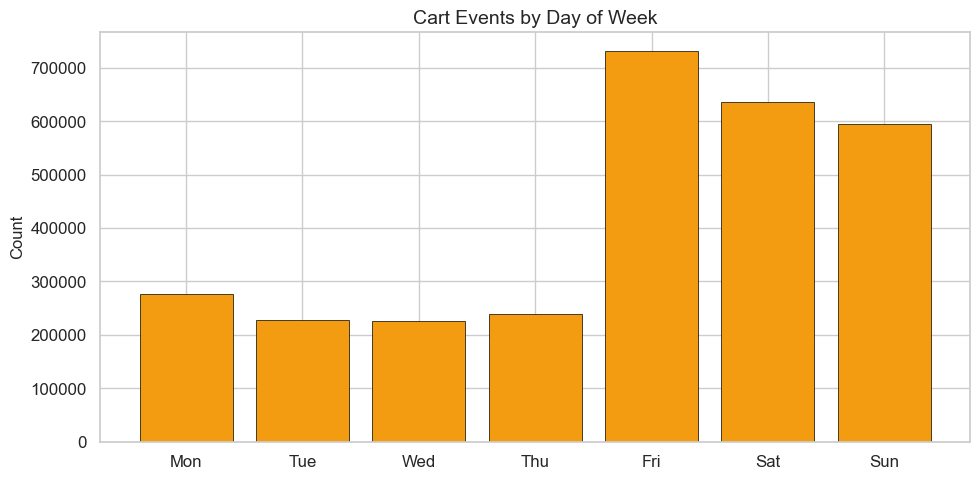

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
weekday_counts = df["event_weekday"].value_counts().sort_index()
bars = ax.bar(
    [weekday_labels[i] for i in weekday_counts.index],
    weekday_counts.values,
    color="#f39c12",
    edgecolor="black",
    linewidth=0.5,
)
ax.set_title("Cart Events by Day of Week")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

### 2.5 User-level Feature Distributions

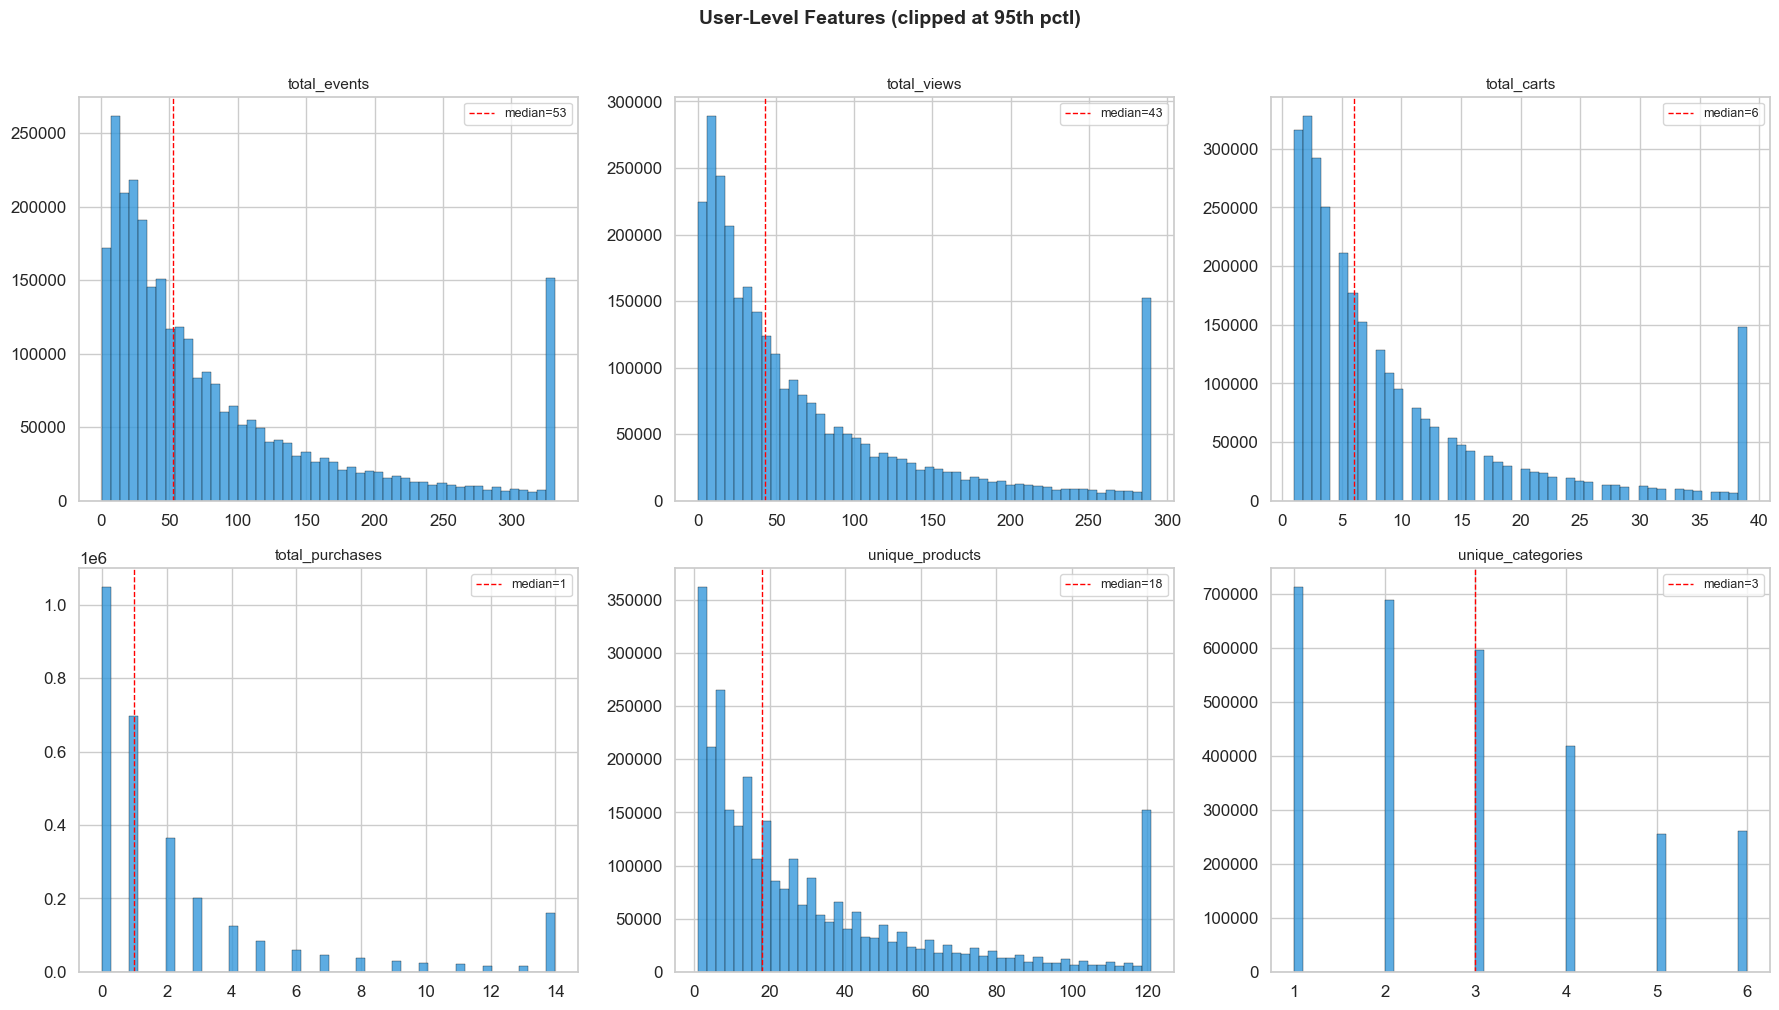

In [15]:
user_features = [
    "user_total_events", "user_total_views", "user_total_carts",
    "user_total_purchases", "user_unique_products", "user_unique_categories",
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flatten(), user_features):
    data_clipped = df[col].clip(upper=df[col].quantile(0.95))
    ax.hist(data_clipped, bins=50, color="#3498db", edgecolor="black", linewidth=0.3, alpha=0.8)
    ax.set_title(col.replace("user_", ""), fontsize=11)
    ax.set_xlabel("")
    ax.axvline(df[col].median(), color="red", linestyle="--", linewidth=1, label=f"median={df[col].median():.0f}")
    ax.legend(fontsize=9)

plt.suptitle("User-Level Features (clipped at 95th pctl)", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 2.6 User Conversion Rate Distributions

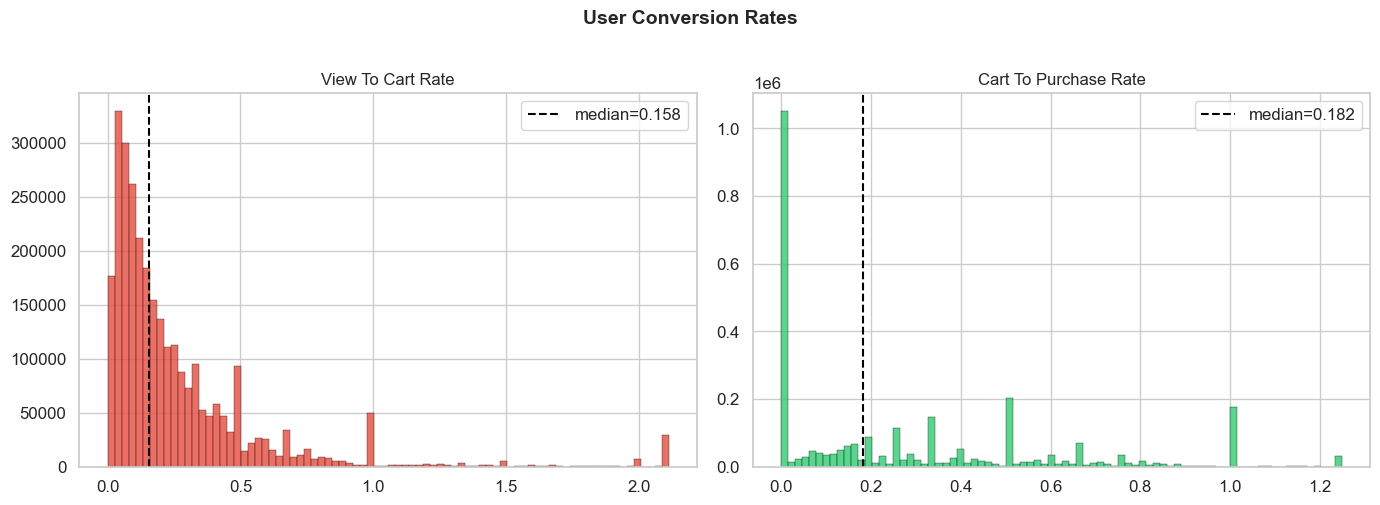

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, color in zip(
    axes,
    ["user_view_to_cart_rate", "user_cart_to_purchase_rate"],
    ["#e74c3c", "#2ecc71"],
):
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    ax.hist(clipped, bins=80, color=color, edgecolor="black", linewidth=0.3, alpha=0.8)
    ax.set_title(col.replace("user_", "").replace("_", " ").title(), fontsize=12)
    ax.axvline(df[col].median(), color="black", linestyle="--", label=f"median={df[col].median():.3f}")
    ax.legend()

plt.suptitle("User Conversion Rates", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 2.7 Product-level Feature Distributions

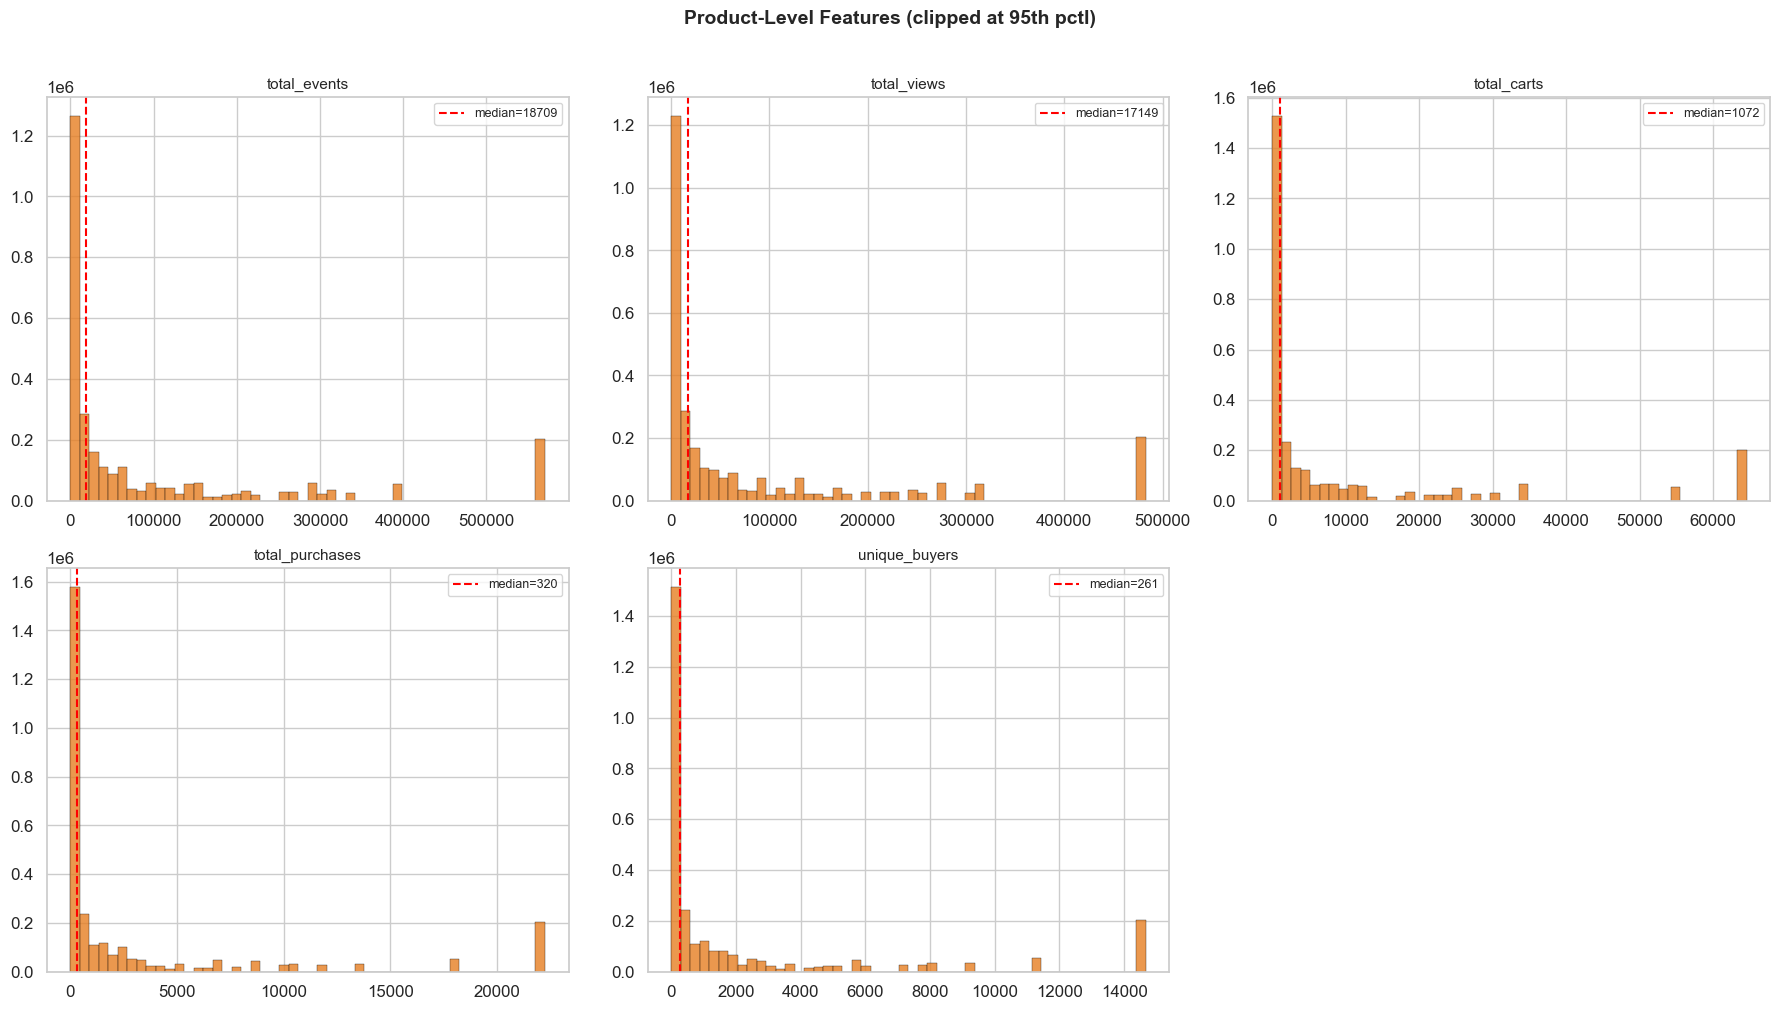

In [17]:
product_features = [
    "product_total_events", "product_total_views", "product_total_carts",
    "product_total_purchases", "product_unique_buyers",
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(product_features):
    ax = axes.flatten()[i]
    data_clipped = df[col].clip(upper=df[col].quantile(0.95))
    ax.hist(data_clipped, bins=50, color="#e67e22", edgecolor="black", linewidth=0.3, alpha=0.8)
    ax.set_title(col.replace("product_", ""), fontsize=11)
    ax.axvline(df[col].median(), color="red", linestyle="--", label=f"median={df[col].median():.0f}")
    ax.legend(fontsize=9)

axes.flatten()[-1].axis("off")  # hide unused subplot
plt.suptitle("Product-Level Features (clipped at 95th pctl)", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 2.8 Product Conversion Rate Distributions

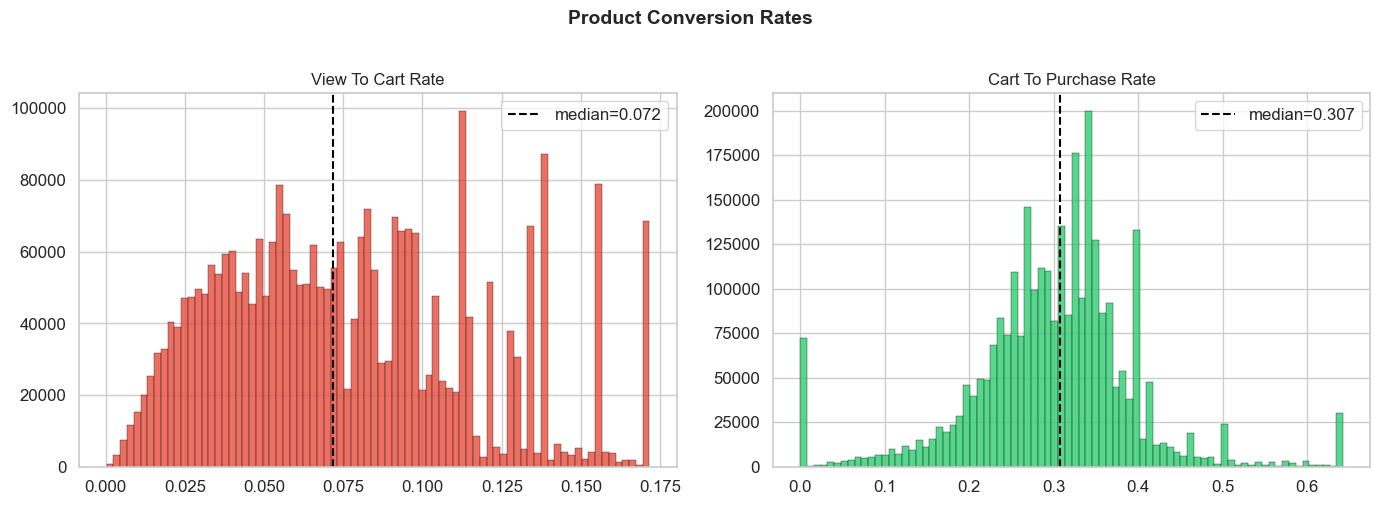

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, color in zip(
    axes,
    ["product_view_to_cart_rate", "product_cart_to_purchase_rate"],
    ["#e74c3c", "#2ecc71"],
):
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    ax.hist(clipped, bins=80, color=color, edgecolor="black", linewidth=0.3, alpha=0.8)
    ax.set_title(col.replace("product_", "").replace("_", " ").title(), fontsize=12)
    ax.axvline(df[col].median(), color="black", linestyle="--", label=f"median={df[col].median():.3f}")
    ax.legend()

plt.suptitle("Product Conversion Rates", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 2.9 Price Comparison Features

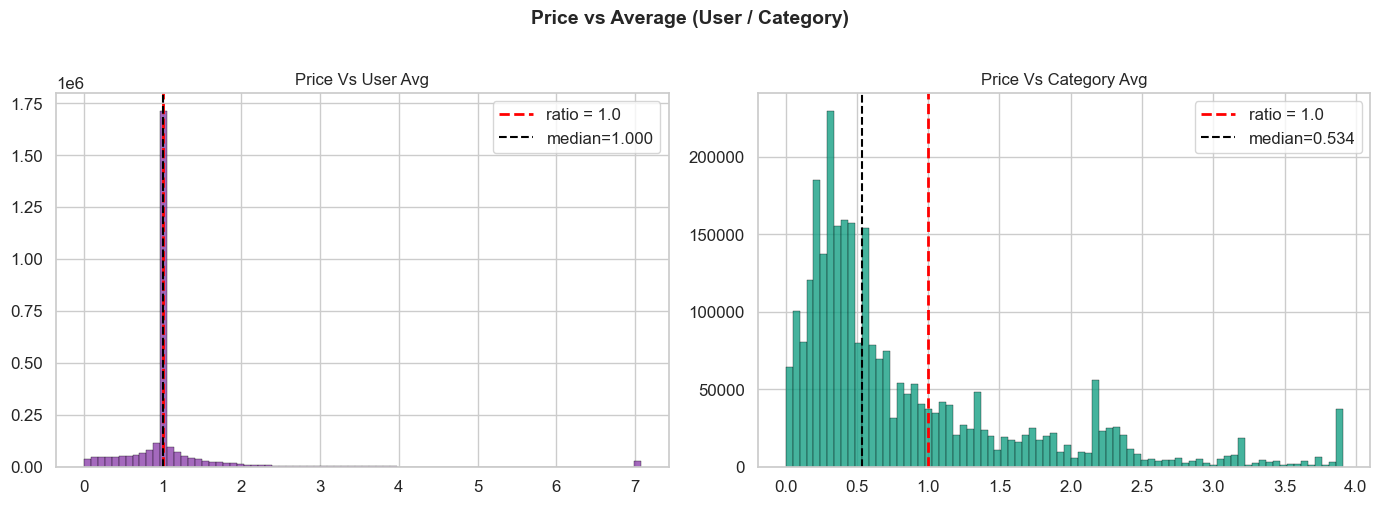

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, color in zip(
    axes,
    ["price_vs_user_avg", "price_vs_category_avg"],
    ["#8e44ad", "#16a085"],
):
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    ax.hist(clipped, bins=80, color=color, edgecolor="black", linewidth=0.3, alpha=0.8)
    ax.set_title(col.replace("_", " ").title(), fontsize=12)
    ax.axvline(1.0, color="red", linestyle="--", linewidth=2, label="ratio = 1.0")
    ax.axvline(df[col].median(), color="black", linestyle="--", label=f"median={df[col].median():.3f}")
    ax.legend()

plt.suptitle("Price vs Average (User / Category)", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 2.10 Box Plots — Outlier Detection

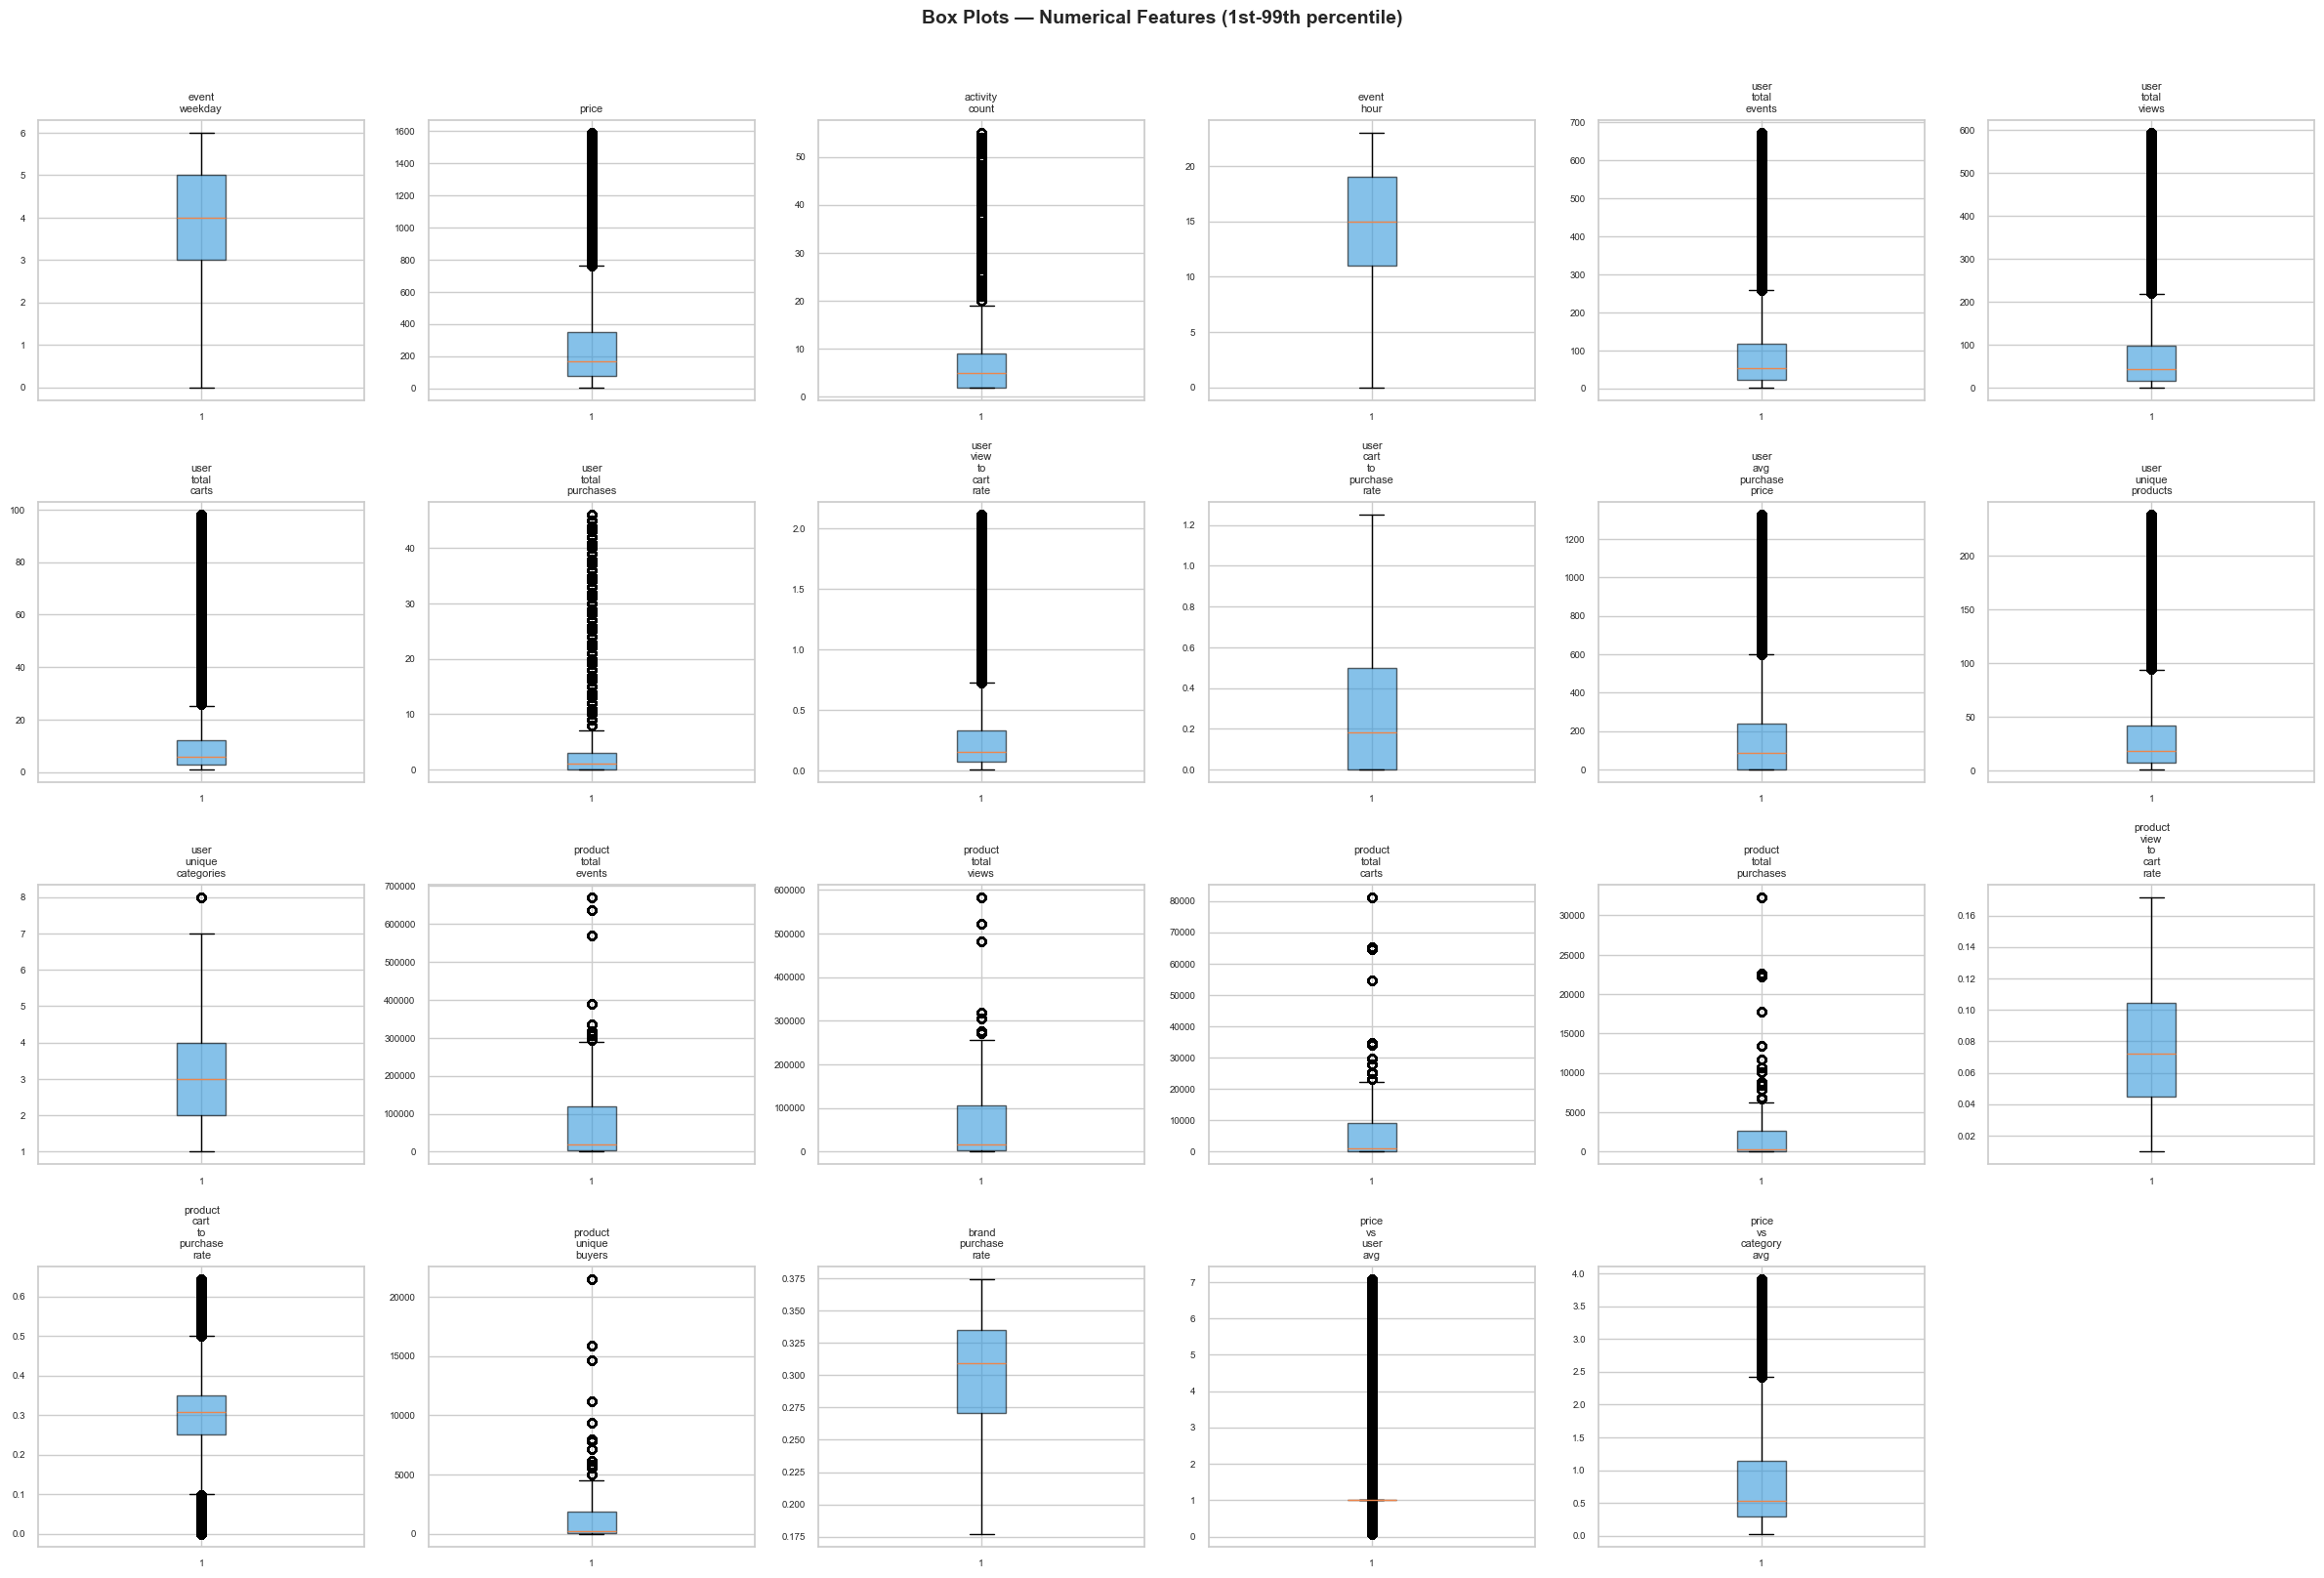

In [20]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c not in ["is_purchased", "user_id", "product_id"]]

fig, axes = plt.subplots(4, 6, figsize=(24, 16))
for i, col in enumerate(numerical_cols):
    ax = axes.flatten()[i]
    data_clipped = df[col].clip(
        lower=df[col].quantile(0.01),
        upper=df[col].quantile(0.99),
    )
    ax.boxplot(data_clipped.dropna(), vert=True, patch_artist=True,
               boxprops=dict(facecolor="#3498db", alpha=0.6))
    ax.set_title(col.replace("_", "\n"), fontsize=8)
    ax.tick_params(labelsize=7)

# Hide unused subplots
for j in range(len(numerical_cols), len(axes.flatten())):
    axes.flatten()[j].axis("off")

plt.suptitle("Box Plots — Numerical Features (1st-99th percentile)", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

---
# Phase 3: Univariate Analysis — Categorical Features

### 3.1 Category Code Level 1

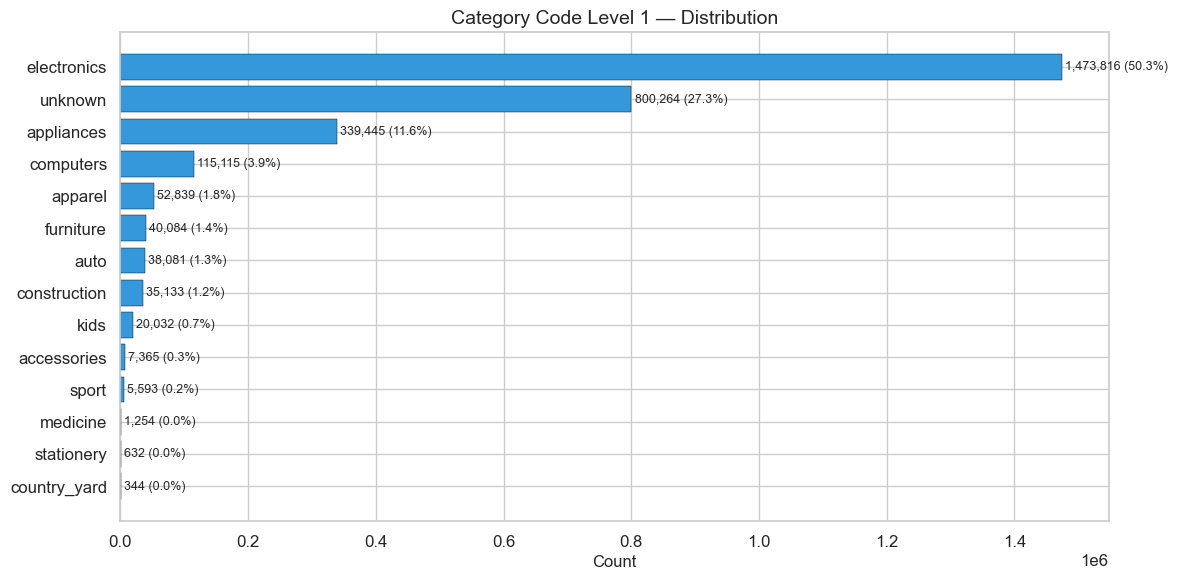

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
cat1_counts = df["category_code_level1"].value_counts()
bars = ax.barh(cat1_counts.index[::-1], cat1_counts.values[::-1], color="#3498db", edgecolor="black", linewidth=0.3)
ax.set_title("Category Code Level 1 — Distribution")
ax.set_xlabel("Count")
for bar, count in zip(bars, cat1_counts.values[::-1]):
    ax.text(bar.get_width() + 5000, bar.get_y() + bar.get_height() / 2,
            f"{count:,} ({count / len(df) * 100:.1f}%)", va="center", fontsize=9)
plt.tight_layout()
plt.show()

### 3.2 Category Code Level 2 (Top 20)

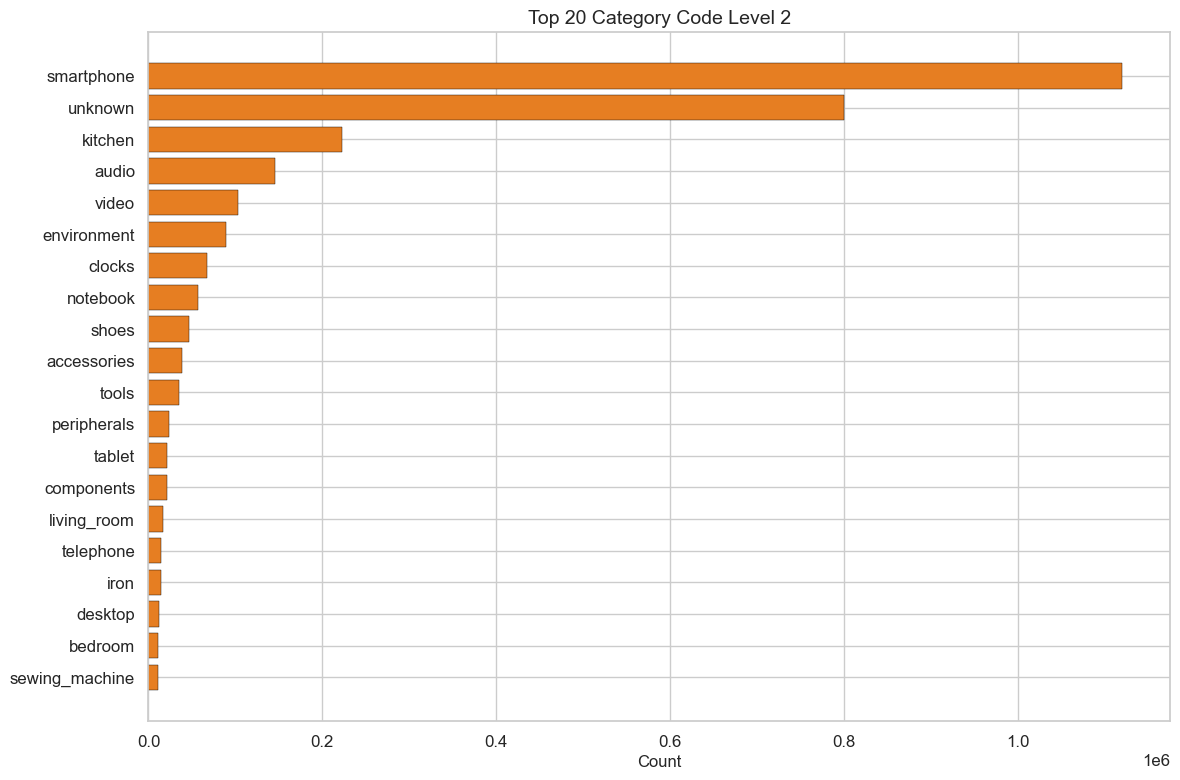

Total unique category_code_level2: 58


In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
cat2_counts = df["category_code_level2"].value_counts().head(20)
ax.barh(cat2_counts.index[::-1], cat2_counts.values[::-1], color="#e67e22", edgecolor="black", linewidth=0.3)
ax.set_title("Top 20 Category Code Level 2")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()
print(f"Total unique category_code_level2: {df['category_code_level2'].nunique()}")

### 3.3 Top 20 Brands

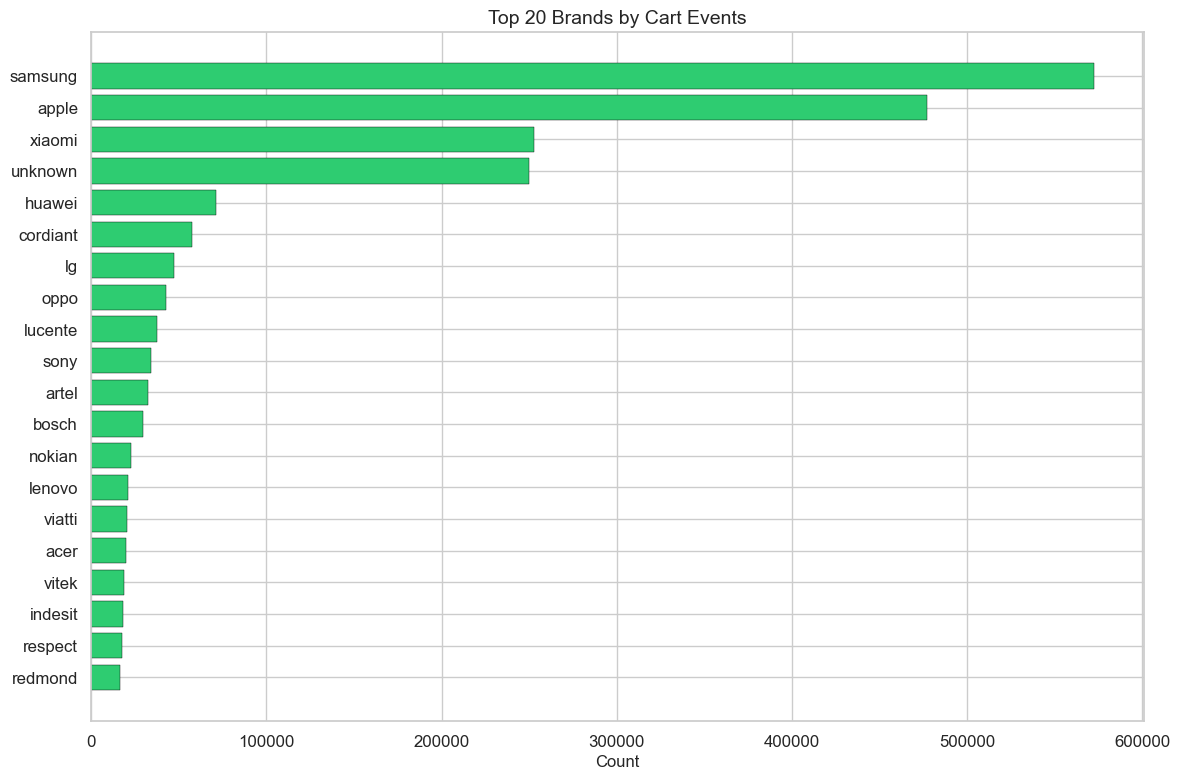

Total unique brands: 3058


In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
brand_counts = df["brand"].value_counts().head(20)
ax.barh(brand_counts.index[::-1], brand_counts.values[::-1], color="#2ecc71", edgecolor="black", linewidth=0.3)
ax.set_title("Top 20 Brands by Cart Events")
ax.set_xlabel("Count")
plt.tight_layout()
plt.show()
print(f"Total unique brands: {df['brand'].nunique()}")

### 3.4 Brand Long-tail (Cumulative Distribution)

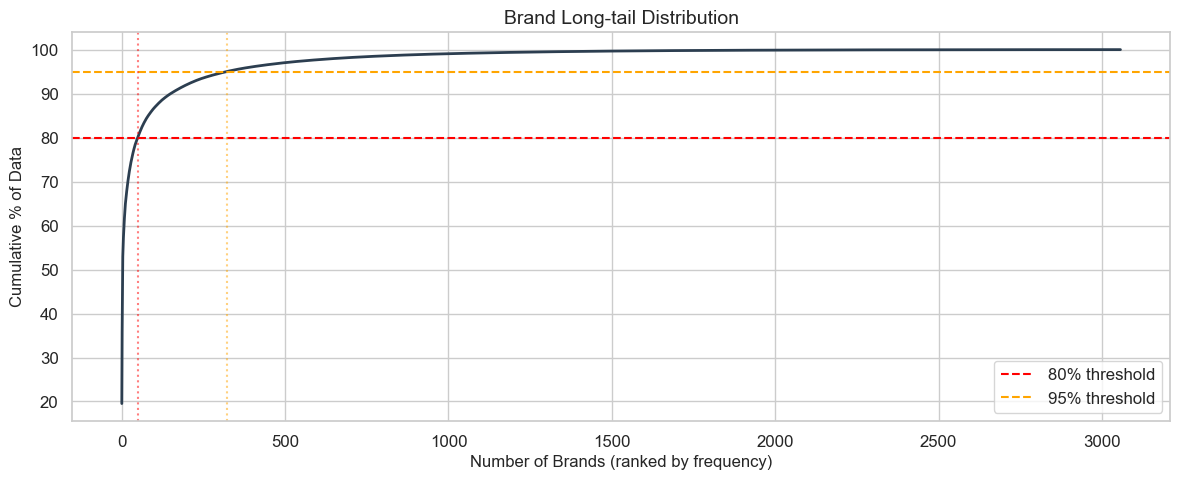

Top 49 brands cover 80% of data (out of 3058 total)
Top 321 brands cover 95% of data


In [24]:
brand_counts_all = df["brand"].value_counts()
cumulative_pct = brand_counts_all.cumsum() / brand_counts_all.sum() * 100

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(len(cumulative_pct)), cumulative_pct.values, color="#2c3e50", linewidth=2)
ax.axhline(80, color="red", linestyle="--", label="80% threshold")
ax.axhline(95, color="orange", linestyle="--", label="95% threshold")

# Find indices
n_80 = (cumulative_pct <= 80).sum()
n_95 = (cumulative_pct <= 95).sum()
ax.axvline(n_80, color="red", linestyle=":", alpha=0.5)
ax.axvline(n_95, color="orange", linestyle=":", alpha=0.5)

ax.set_title("Brand Long-tail Distribution")
ax.set_xlabel("Number of Brands (ranked by frequency)")
ax.set_ylabel("Cumulative % of Data")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Top {n_80} brands cover 80% of data (out of {len(brand_counts_all)} total)")
print(f"Top {n_95} brands cover 95% of data")

---
# Phase 4: Bivariate Analysis — Feature vs Target

### 4.1 Purchase Rate by Hour

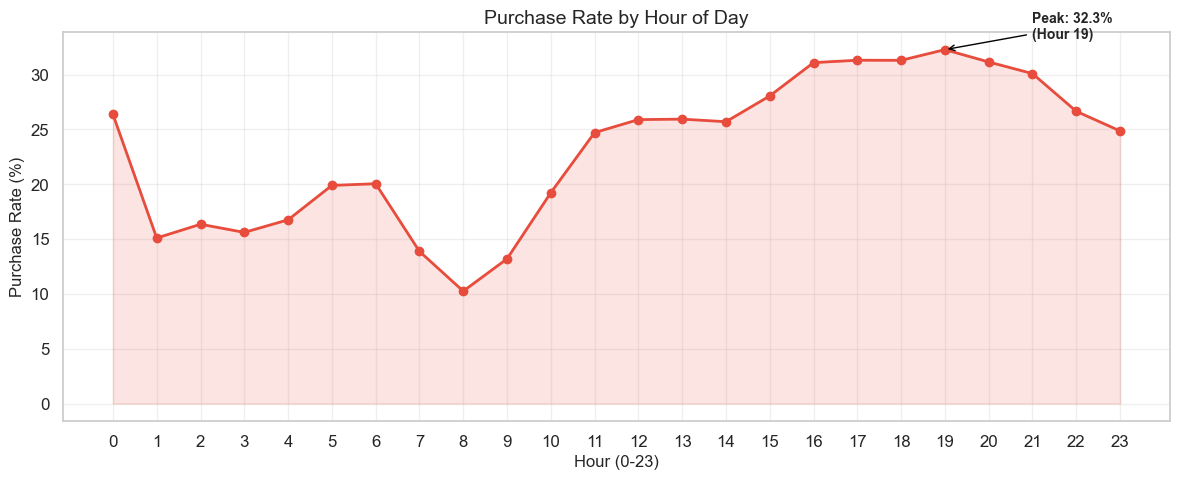

In [25]:
hourly_rate = df.groupby("event_hour")["is_purchased"].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(hourly_rate.index, hourly_rate.values * 100, marker="o", linewidth=2, color="#e74c3c", markersize=6)
ax.fill_between(hourly_rate.index, hourly_rate.values * 100, alpha=0.15, color="#e74c3c")
ax.set_title("Purchase Rate by Hour of Day")
ax.set_xlabel("Hour (0-23)")
ax.set_ylabel("Purchase Rate (%)")
ax.set_xticks(range(24))
ax.grid(True, alpha=0.3)

# Annotate peak
peak_hour = hourly_rate.idxmax()
ax.annotate(
    f"Peak: {hourly_rate.max() * 100:.1f}%\n(Hour {peak_hour})",
    xy=(peak_hour, hourly_rate.max() * 100),
    xytext=(peak_hour + 2, hourly_rate.max() * 100 + 1),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=10,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

Nhận xét biểu đồ: **4.1 Purchase Rate by Hour**

- **Xu hướng chính:** Tỷ lệ mua theo giờ thường tạo 2 cụm: khung giờ làm việc và khung giờ tối; đây là dấu hiệu hành vi mua chịu ảnh hưởng mạnh bởi thời điểm trong ngày.
- **Điểm bất thường/outlier:** Nếu một vài giờ có purchase rate tăng vọt nhưng số lượng sự kiện thấp, đây có thể là nhiễu do mẫu nhỏ thay vì tín hiệu thật.
- **Hàm ý cho mô hình:** `event_hour` nên được giữ lại và cân nhắc thêm đặc trưng chu kỳ (sin/cos theo giờ) để mô hình học tính tuần hoàn tốt hơn.
- **Hành động tiếp theo:** Tạo thêm feature `is_peak_hour` và so sánh AUC/PR-AUC trước-sau khi thêm feature này.


### 4.2 Purchase Rate by Weekday

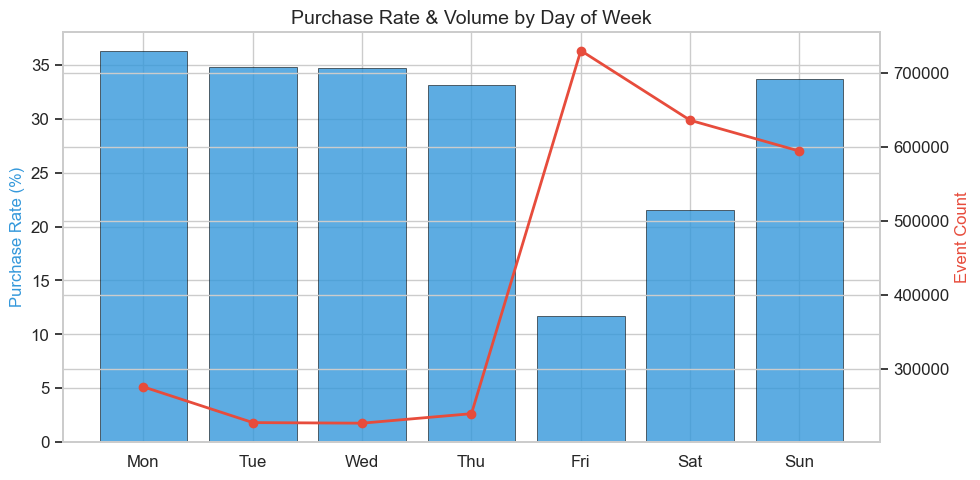

In [26]:
weekday_rate = df.groupby("event_weekday")["is_purchased"].agg(["mean", "count"])
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, ax1 = plt.subplots(figsize=(10, 5))
bars = ax1.bar(
    [weekday_labels[i] for i in weekday_rate.index],
    weekday_rate["mean"] * 100,
    color="#3498db",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8,
)
ax1.set_ylabel("Purchase Rate (%)", color="#3498db")
ax1.set_title("Purchase Rate & Volume by Day of Week")

ax2 = ax1.twinx()
ax2.plot(
    [weekday_labels[i] for i in weekday_rate.index],
    weekday_rate["count"],
    color="#e74c3c",
    marker="o",
    linewidth=2,
    label="Event Count",
)
ax2.set_ylabel("Event Count", color="#e74c3c")

plt.tight_layout()
plt.show()

Nhận xét biểu đồ: **4.2 Purchase Rate by Weekday**

- **Xu hướng chính:** Purchase rate biến thiên theo ngày trong tuần cho thấy hành vi mua không đồng nhất giữa weekday và cuối tuần.
- **Điểm bất thường/outlier:** Ngày có volume thấp nhưng rate cao cần đọc cùng đường count để tránh kết luận sai do base nhỏ.
- **Hàm ý cho mô hình:** `event_weekday` là feature có ý nghĩa ngữ cảnh; nên mã hóa dạng cyclical hoặc target encoding theo ngày để giữ thông tin thứ tự tuần.
- **Hành động tiếp theo:** So sánh hiệu quả giữa one-hot weekday và cyclical encoding trong cùng cấu hình train/validation.


### 4.3 Purchase Rate by Category Level 1

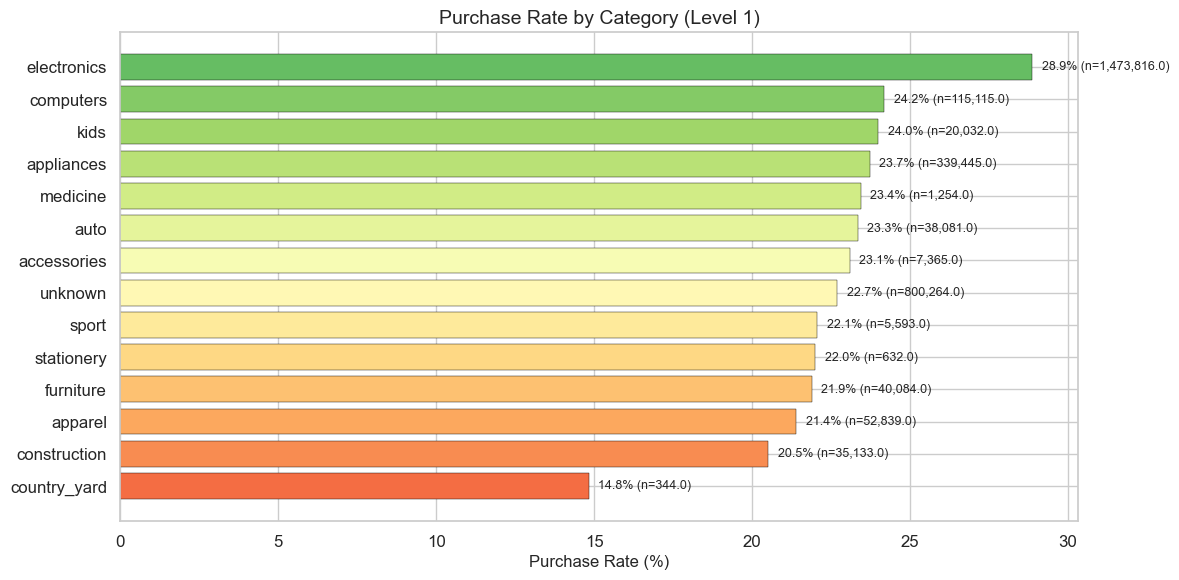

In [27]:
cat1_rate = df.groupby("category_code_level1")["is_purchased"].agg(["mean", "count"])
cat1_rate = cat1_rate.sort_values("mean", ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(cat1_rate)))
bars = ax.barh(cat1_rate.index, cat1_rate["mean"] * 100, color=colors, edgecolor="black", linewidth=0.3)

for bar, (idx, row) in zip(bars, cat1_rate.iterrows()):
    ax.text(
        bar.get_width() + 0.3,
        bar.get_y() + bar.get_height() / 2,
        f"{row['mean'] * 100:.1f}% (n={row['count']:,})",
        va="center",
        fontsize=9,
    )

ax.set_title("Purchase Rate by Category (Level 1)")
ax.set_xlabel("Purchase Rate (%)")
plt.tight_layout()
plt.show()

Nhận xét biểu đồ: **4.3 Purchase Rate by Category Level 1**

- **Xu hướng chính:** Chênh lệch purchase rate giữa các nhóm category level 1 khá rõ, phản ánh intent mua hàng khác nhau theo ngành hàng.
- **Điểm bất thường/outlier:** Category có rate rất cao nhưng số mẫu nhỏ có thể là niche segment, cần kiểm tra độ ổn định theo thời gian.
- **Hàm ý cho mô hình:** `category_code_level1` là feature phân tách mạnh; có thể dùng thêm aggregate theo category (historical conversion) để tăng tín hiệu.
- **Hành động tiếp theo:** Áp dụng smoothing cho category conversion rate để tránh overfit ở category hiếm.


### 4.4 Purchase Rate by Category Level 2 (Top 20 by volume)

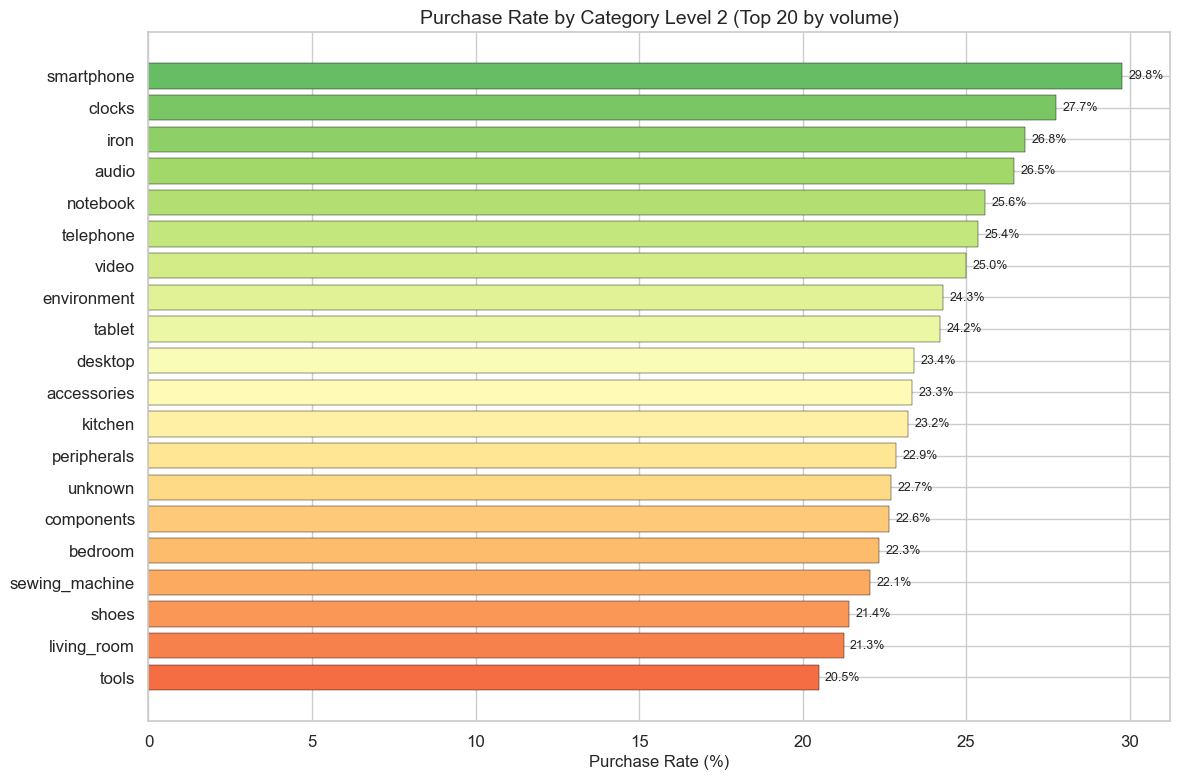

In [28]:
top20_cat2 = df["category_code_level2"].value_counts().head(20).index
cat2_rate = (
    df[df["category_code_level2"].isin(top20_cat2)]
    .groupby("category_code_level2")["is_purchased"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=True)
)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(cat2_rate)))
bars = ax.barh(cat2_rate.index, cat2_rate["mean"] * 100, color=colors, edgecolor="black", linewidth=0.3)
for bar, (idx, row) in zip(bars, cat2_rate.iterrows()):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2,
            f"{row['mean'] * 100:.1f}%", va="center", fontsize=9)
ax.set_title("Purchase Rate by Category Level 2 (Top 20 by volume)")
ax.set_xlabel("Purchase Rate (%)")
plt.tight_layout()
plt.show()

Nhận xét biểu đồ: **4.4 Purchase Rate by Category Level 2 (Top 20 by volume)**

- **Xu hướng chính:** Ở level 2, khoảng cách conversion rõ hơn level 1, cho thấy granularity chi tiết giúp phân biệt nhu cầu mua tốt hơn.
- **Điểm bất thường/outlier:** Một vài subcategory có conversion rất cao có thể bị ảnh hưởng bởi campaign ngắn hạn hoặc seasonality.
- **Hàm ý cho mô hình:** `category_code_level2` là tín hiệu quan trọng nhưng cardinality cao, cần kỹ thuật mã hóa an toàn (target encoding có regularization hoặc hashing).
- **Hành động tiếp theo:** Kiểm tra drift conversion theo tháng cho top subcategory trước khi đưa vào feature store online.


### 4.5 Purchase Rate by Top 20 Brands

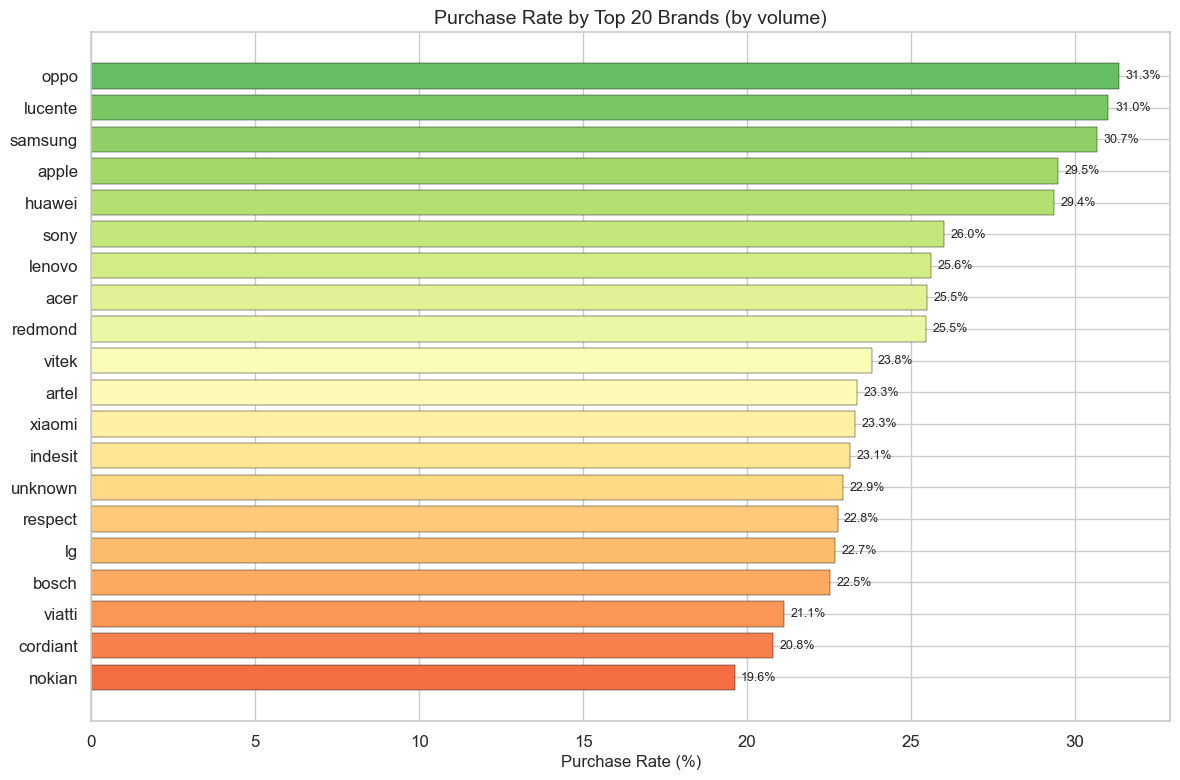

In [29]:
top20_brands = df["brand"].value_counts().head(20).index
brand_rate = (
    df[df["brand"].isin(top20_brands)]
    .groupby("brand")["is_purchased"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=True)
)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(brand_rate)))
bars = ax.barh(brand_rate.index, brand_rate["mean"] * 100, color=colors, edgecolor="black", linewidth=0.3)
for bar, (idx, row) in zip(bars, brand_rate.iterrows()):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2,
            f"{row['mean'] * 100:.1f}%", va="center", fontsize=9)
ax.set_title("Purchase Rate by Top 20 Brands (by volume)")
ax.set_xlabel("Purchase Rate (%)")
plt.tight_layout()
plt.show()

Nhận xét biểu đồ: **4.5 Purchase Rate by Top 20 Brands**

- **Xu hướng chính:** Brand top volume không đồng nghĩa brand top conversion; có sự khác biệt giữa mức độ phổ biến và xác suất mua.
- **Điểm bất thường/outlier:** Brand có rate thấp nhưng volume lớn thường tạo nhiều false positive nếu mô hình không học đủ ngữ cảnh giá/category.
- **Hàm ý cho mô hình:** Cần kết hợp `brand` với feature ngữ cảnh (`price_vs_category_avg`, category) thay vì dùng brand độc lập.
- **Hành động tiếp theo:** Tạo feature tương tác `brand x category_level1` cho top brand và đánh giá gain bằng validation.


### 4.6 Price Distribution by Target

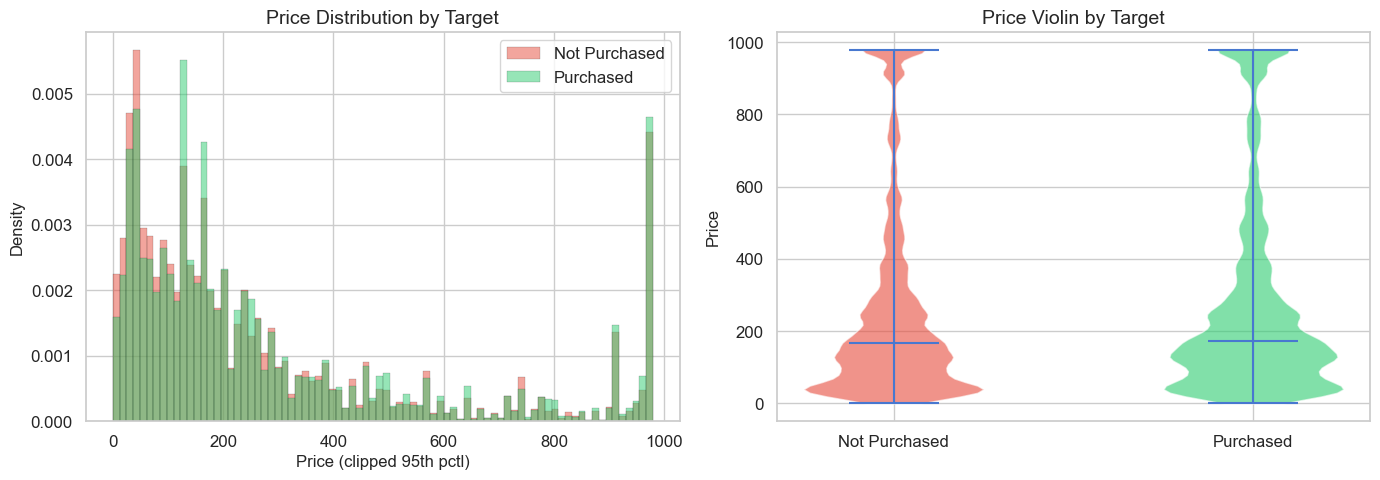

Median price:
  Not Purchased: 166.80
  Purchased:     172.12


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overlapping histogram
price_clip = df["price"].clip(upper=df["price"].quantile(0.95))
for label, color, name in [(0, "#e74c3c", "Not Purchased"), (1, "#2ecc71", "Purchased")]:
    axes[0].hist(
        price_clip[df["is_purchased"] == label],
        bins=80, alpha=0.5, color=color, label=name, density=True,
        edgecolor="black", linewidth=0.2,
    )
axes[0].set_title("Price Distribution by Target")
axes[0].set_xlabel("Price (clipped 95th pctl)")
axes[0].set_ylabel("Density")
axes[0].legend()

# Violin plot
parts = axes[1].violinplot(
    [price_clip[df["is_purchased"] == 0], price_clip[df["is_purchased"] == 1]],
    positions=[0, 1], showmedians=True, showextrema=True,
)
for i, pc in enumerate(parts["bodies"]):
    pc.set_facecolor(["#e74c3c", "#2ecc71"][i])
    pc.set_alpha(0.6)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Not Purchased", "Purchased"])
axes[1].set_title("Price Violin by Target")
axes[1].set_ylabel("Price")

plt.tight_layout()
plt.show()

print("Median price:")
print(f"  Not Purchased: {df.loc[df['is_purchased'] == 0, 'price'].median():.2f}")
print(f"  Purchased:     {df.loc[df['is_purchased'] == 1, 'price'].median():.2f}")

Nhận xét biểu đồ: **4.6 Price Distribution by Target**

- **Xu hướng chính:** Phân phối giá giữa 2 lớp thường chồng lấp mạnh, nghĩa là giá đơn lẻ chưa đủ để quyết định mua hay không mua.
- **Điểm bất thường/outlier:** Đuôi giá cao có thể kéo lệch thống kê trung bình, nên median/quantile đại diện tốt hơn mean.
- **Hàm ý cho mô hình:** Nên ưu tiên feature tương đối như `price_vs_user_avg` và `price_vs_category_avg` thay cho giá tuyệt đối.
- **Hành động tiếp theo:** Thử log-transform cho `price` và so sánh feature importance sau huấn luyện.


### 4.7 Activity Count by Target

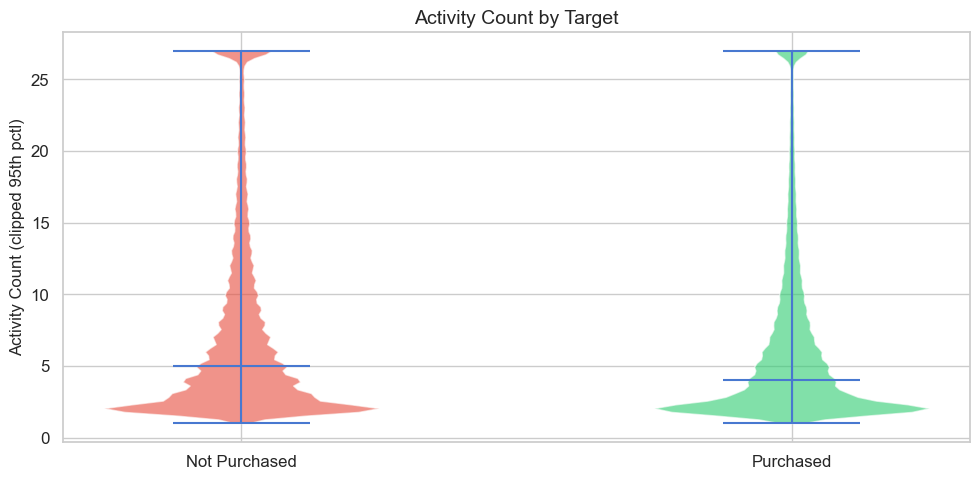

Median activity_count:
  Not Purchased: 5
  Purchased:     4


In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
activity_clip = df["activity_count"].clip(upper=df["activity_count"].quantile(0.95))

parts = ax.violinplot(
    [activity_clip[df["is_purchased"] == 0], activity_clip[df["is_purchased"] == 1]],
    positions=[0, 1], showmedians=True, showextrema=True,
)
for i, pc in enumerate(parts["bodies"]):
    pc.set_facecolor(["#e74c3c", "#2ecc71"][i])
    pc.set_alpha(0.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Purchased", "Purchased"])
ax.set_title("Activity Count by Target")
ax.set_ylabel("Activity Count (clipped 95th pctl)")
plt.tight_layout()
plt.show()

print("Median activity_count:")
print(f"  Not Purchased: {df.loc[df['is_purchased'] == 0, 'activity_count'].median():.0f}")
print(f"  Purchased:     {df.loc[df['is_purchased'] == 1, 'activity_count'].median():.0f}")

Nhận xét biểu đồ: **4.7 Activity Count by Target**

- **Xu hướng chính:** Activity count thường là tín hiệu intent: nhóm có tương tác sâu hơn có xu hướng chuyển đổi cao hơn.
- **Điểm bất thường/outlier:** Một số phiên có activity rất cao nhưng không mua có thể là hành vi so sánh giá hoặc nhiễu bot.
- **Hàm ý cho mô hình:** `activity_count` nên giữ nguyên và cân nhắc clip/winsorize để giảm tác động của đuôi dài.
- **Hành động tiếp theo:** Thêm feature bucket cho activity (low/medium/high) để tăng tính ổn định và khả năng giải thích.


### 4.8 User Conversion Rates by Target

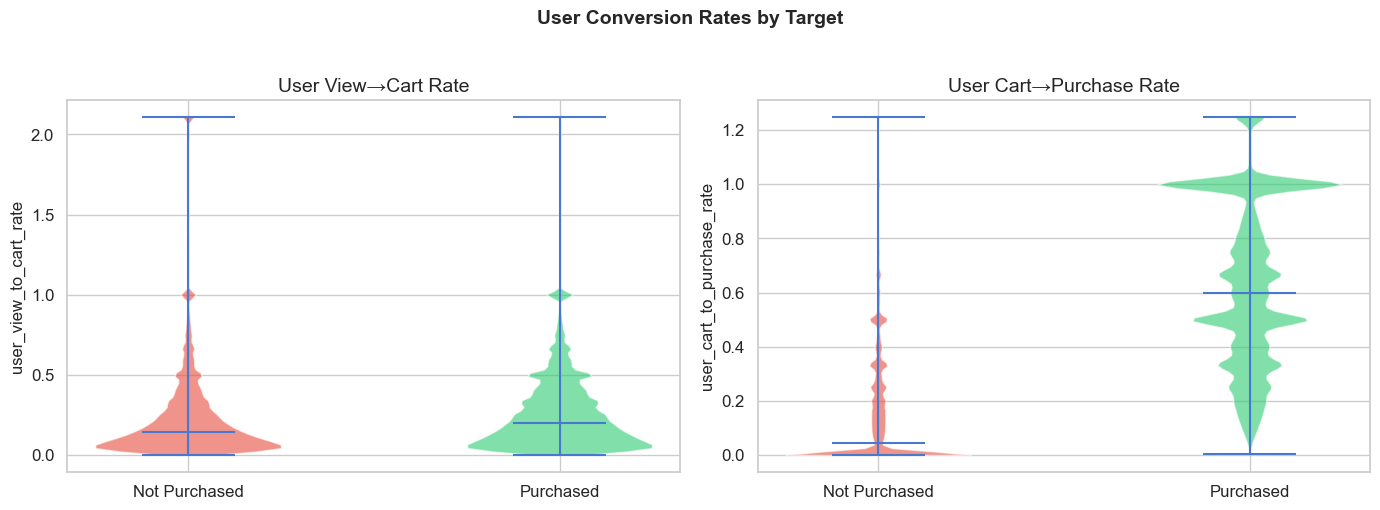

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, title in zip(
    axes,
    ["user_view_to_cart_rate", "user_cart_to_purchase_rate"],
    ["User View→Cart Rate", "User Cart→Purchase Rate"],
):
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    data_0 = clipped[df["is_purchased"] == 0]
    data_1 = clipped[df["is_purchased"] == 1]

    parts = ax.violinplot([data_0, data_1], positions=[0, 1], showmedians=True)
    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(["#e74c3c", "#2ecc71"][i])
        pc.set_alpha(0.6)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Not Purchased", "Purchased"])
    ax.set_title(title)
    ax.set_ylabel(col)

plt.suptitle("User Conversion Rates by Target", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

Nhận xét biểu đồ: **4.8 User Conversion Rates by Target**

- **Xu hướng chính:** Nhóm purchased thường lệch về phía conversion rate cao hơn, xác nhận đây là nhóm feature user-level giàu tín hiệu.
- **Điểm bất thường/outlier:** Các điểm rate rất cao ở người dùng ít lịch sử có thể gây nhiễu, cần xem cùng `user_total_events`.
- **Hàm ý cho mô hình:** Bộ `user_view_to_cart_rate` và `user_cart_to_purchase_rate` nên được ưu tiên trong feature set lõi.
- **Hành động tiếp theo:** Áp dụng Bayesian smoothing cho user conversion rate để xử lý cold-start user.


### 4.9 Product Conversion Rates by Target

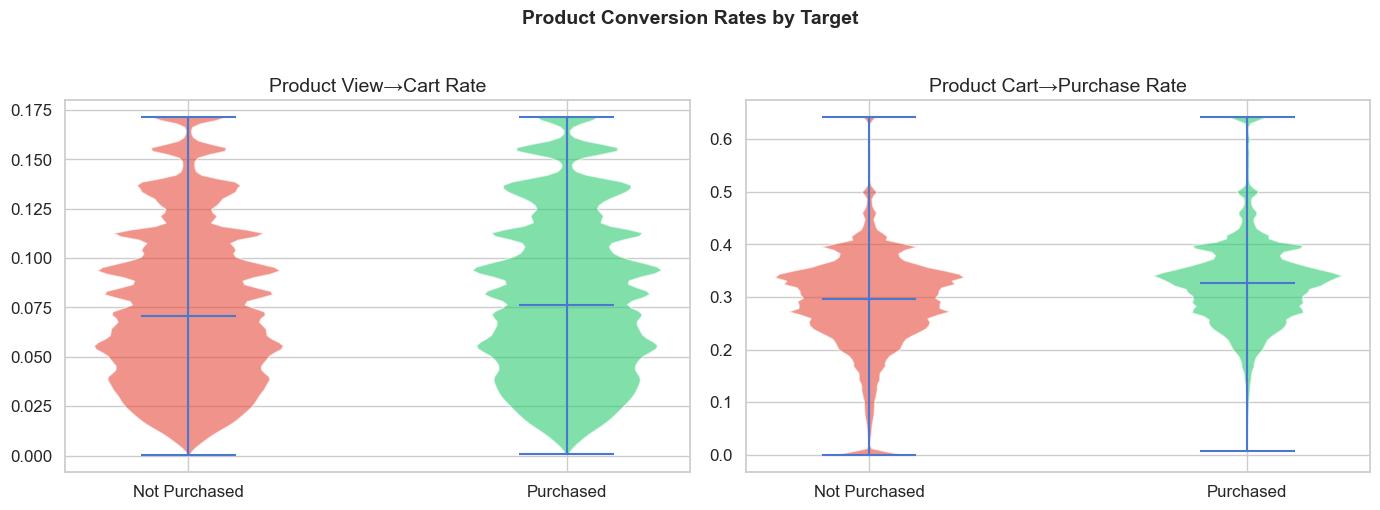

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, title in zip(
    axes,
    ["product_view_to_cart_rate", "product_cart_to_purchase_rate"],
    ["Product View→Cart Rate", "Product Cart→Purchase Rate"],
):
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    data_0 = clipped[df["is_purchased"] == 0]
    data_1 = clipped[df["is_purchased"] == 1]

    parts = ax.violinplot([data_0, data_1], positions=[0, 1], showmedians=True)
    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(["#e74c3c", "#2ecc71"][i])
        pc.set_alpha(0.6)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Not Purchased", "Purchased"])
    ax.set_title(title)

plt.suptitle("Product Conversion Rates by Target", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### 4.10 Brand Purchase Rate by Target

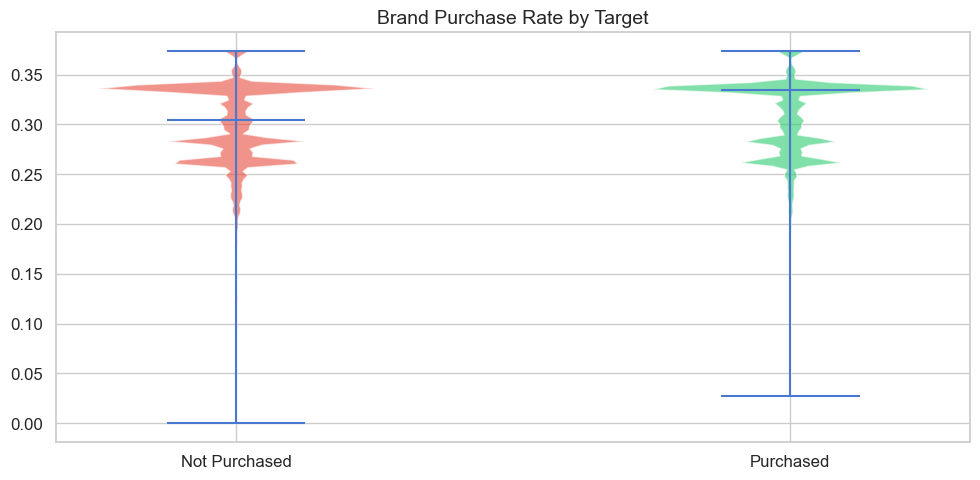

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
clipped = df["brand_purchase_rate"].clip(upper=df["brand_purchase_rate"].quantile(0.99))

parts = ax.violinplot(
    [clipped[df["is_purchased"] == 0], clipped[df["is_purchased"] == 1]],
    positions=[0, 1], showmedians=True,
)
for i, pc in enumerate(parts["bodies"]):
    pc.set_facecolor(["#e74c3c", "#2ecc71"][i])
    pc.set_alpha(0.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Purchased", "Purchased"])
ax.set_title("Brand Purchase Rate by Target")
plt.tight_layout()
plt.show()

### 4.11 Price vs User/Category Avg by Target

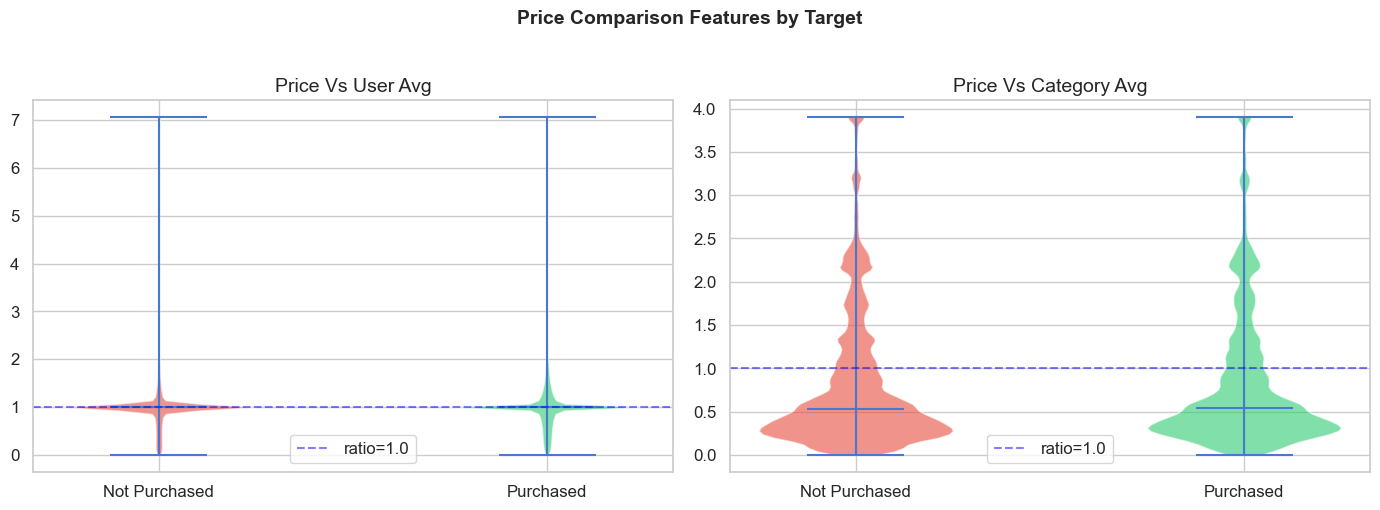

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, ["price_vs_user_avg", "price_vs_category_avg"]):
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    parts = ax.violinplot(
        [clipped[df["is_purchased"] == 0], clipped[df["is_purchased"] == 1]],
        positions=[0, 1], showmedians=True,
    )
    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(["#e74c3c", "#2ecc71"][i])
        pc.set_alpha(0.6)
    ax.axhline(1.0, color="blue", linestyle="--", alpha=0.5, label="ratio=1.0")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Not Purchased", "Purchased"])
    ax.set_title(col.replace("_", " ").title())
    ax.legend()

plt.suptitle("Price Comparison Features by Target", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

---
# Phase 5: Correlation & Multivariate Analysis

### 5.1 Correlation Heatmap

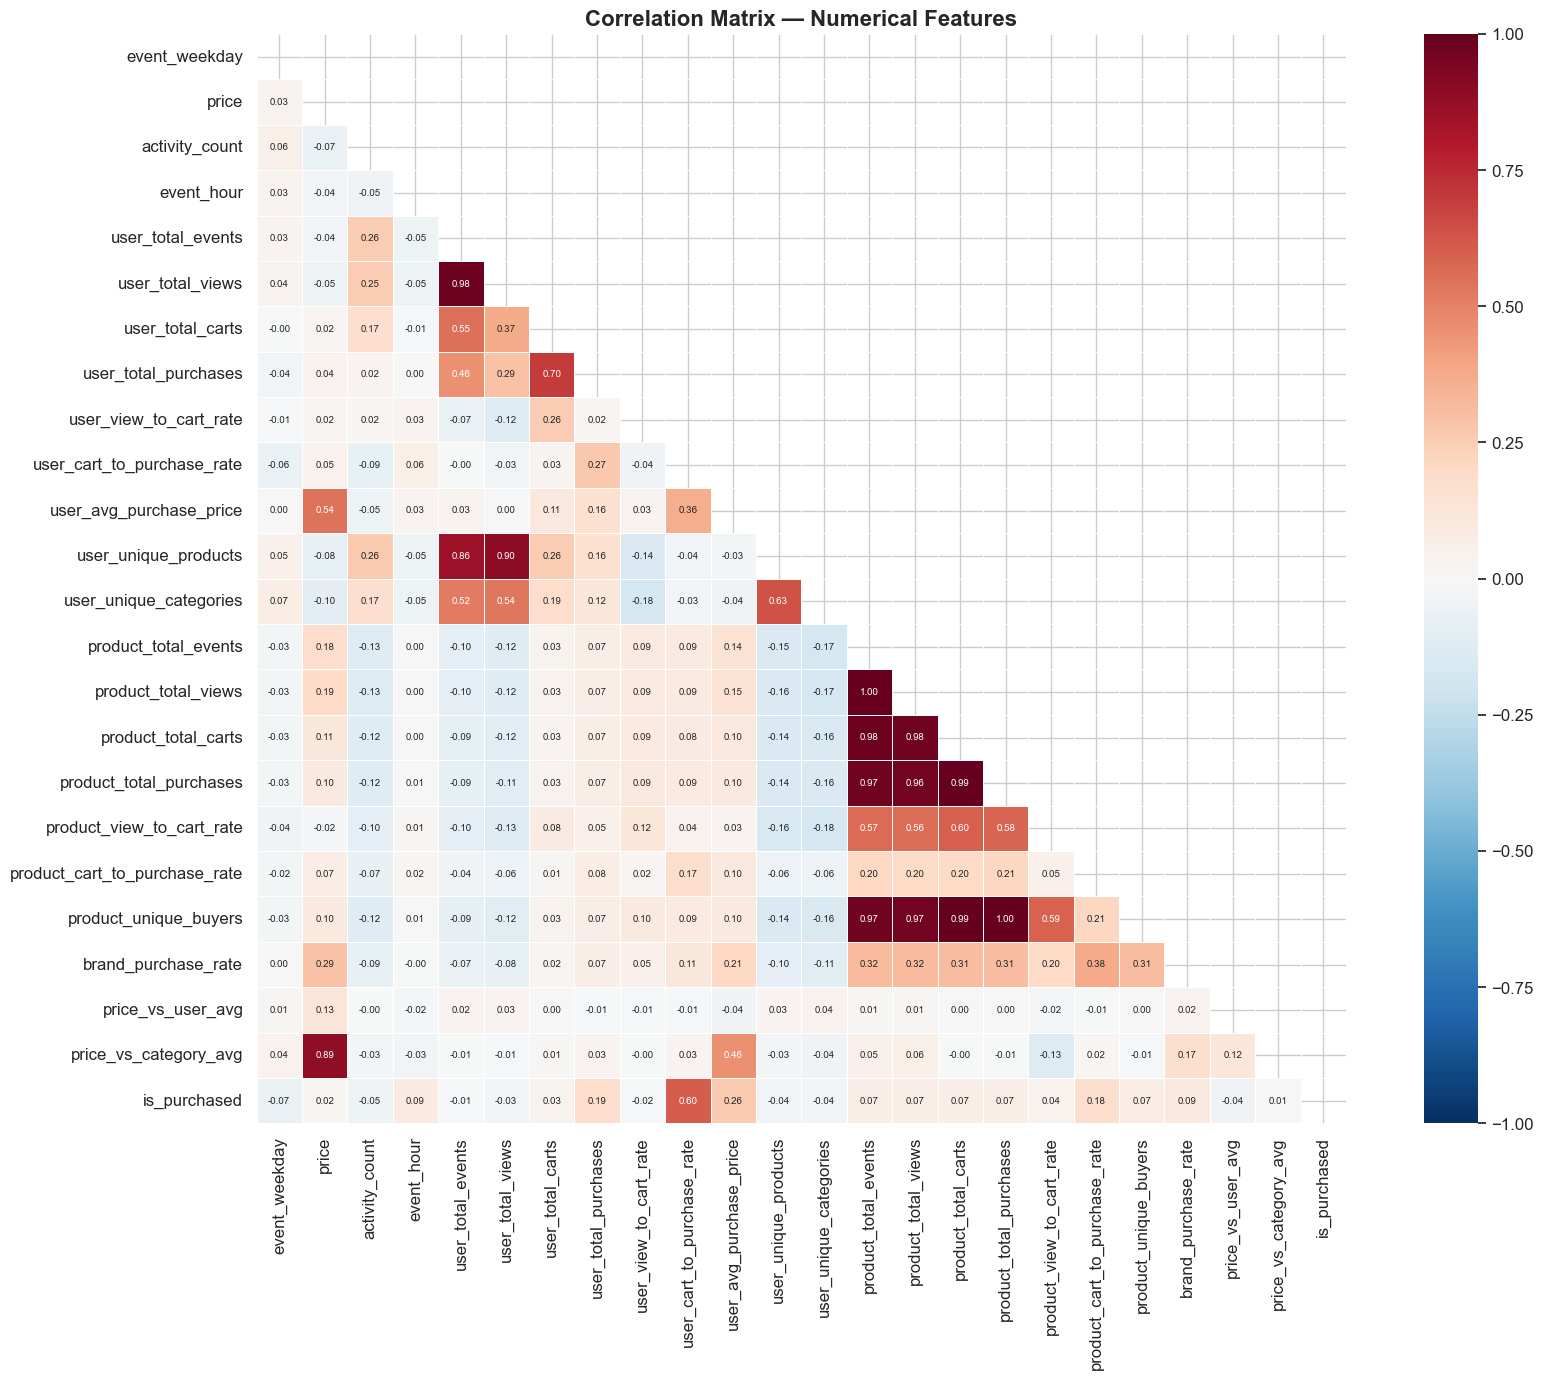

In [36]:
numerical_for_corr = df.select_dtypes(include=[np.number]).drop(
    columns=["user_id", "product_id"], errors="ignore"
)
corr_matrix = numerical_for_corr.corr()

fig, ax = plt.subplots(figsize=(18, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    ax=ax,
    annot_kws={"size": 7},
)
ax.set_title("Correlation Matrix — Numerical Features", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

Nhận xét biểu đồ: **5.1 Correlation Heatmap**

- **Xu hướng chính:** Các cụm feature cùng nhóm (user_*, product_*) thường tương quan cao, phản ánh hiện tượng đa cộng tuyến trong dữ liệu engineered.
- **Điểm bất thường/outlier:** Cặp có tương quan gần 1.0 là ứng viên trùng thông tin; giữ cả hai có thể tăng độ phức tạp mà ít tăng hiệu năng.
- **Hàm ý cho mô hình:** Với mô hình tuyến tính cần kiểm soát multicollinearity; với tree-based vẫn nên giảm feature dư thừa để ổn định SHAP/importance.
- **Hành động tiếp theo:** Lọc cặp |corr| > 0.9, thử bỏ bớt feature và so sánh metric + thời gian train.


### 5.2 Correlation with Target

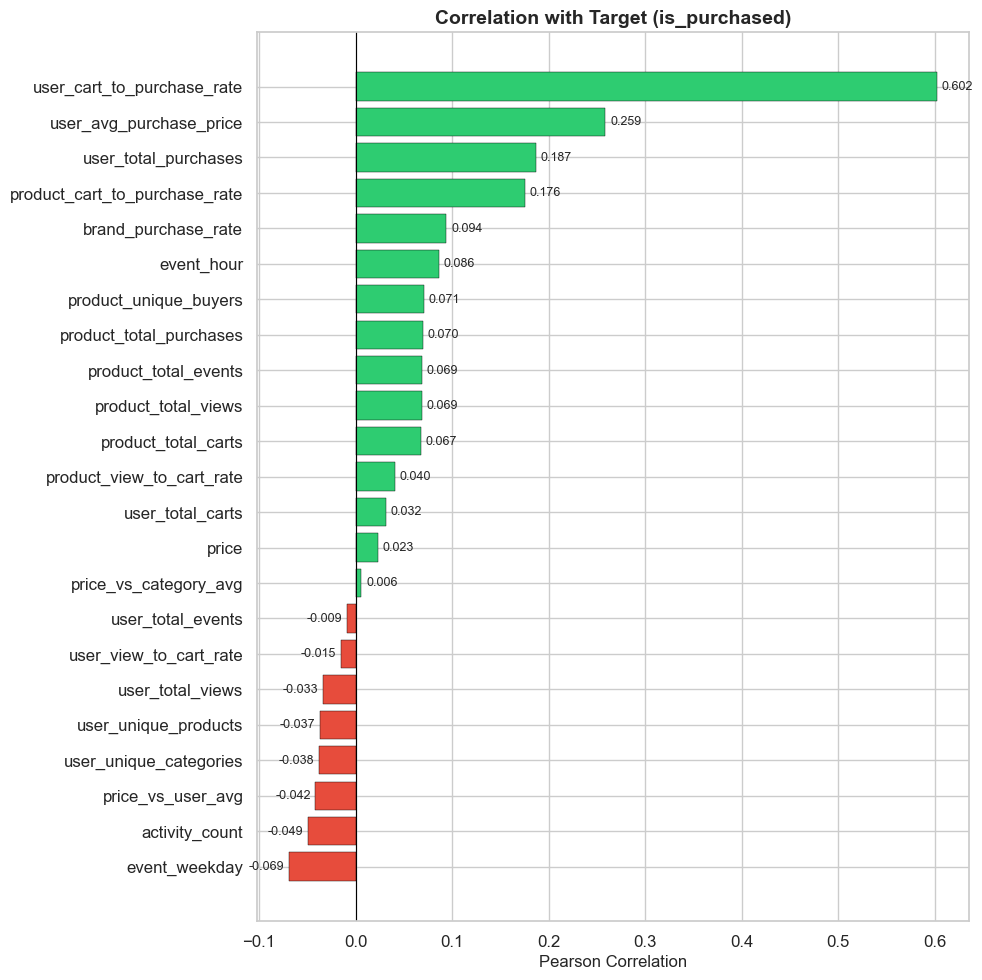


Top 5 positive correlations:
  brand_purchase_rate: 0.0942
  product_cart_to_purchase_rate: 0.1756
  user_total_purchases: 0.1871
  user_avg_purchase_price: 0.2588
  user_cart_to_purchase_rate: 0.6019

Top 5 negative correlations:
  event_weekday: -0.0690
  activity_count: -0.0488
  price_vs_user_avg: -0.0415
  user_unique_categories: -0.0377
  user_unique_products: -0.0369


In [37]:
target_corr = corr_matrix["is_purchased"].drop("is_purchased").sort_values()

fig, ax = plt.subplots(figsize=(10, 10))
colors = ["#e74c3c" if v < 0 else "#2ecc71" for v in target_corr.values]
bars = ax.barh(target_corr.index, target_corr.values, color=colors, edgecolor="black", linewidth=0.3)
ax.axvline(0, color="black", linewidth=0.8)
ax.set_title("Correlation with Target (is_purchased)", fontsize=14, fontweight="bold")
ax.set_xlabel("Pearson Correlation")

for bar, val in zip(bars, target_corr.values):
    x_pos = val + 0.005 if val >= 0 else val - 0.005
    ax.text(x_pos, bar.get_y() + bar.get_height() / 2, f"{val:.3f}",
            va="center", ha="left" if val >= 0 else "right", fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 5 positive correlations:")
for feat, val in target_corr.tail(5).items():
    print(f"  {feat}: {val:.4f}")
print("\nTop 5 negative correlations:")
for feat, val in target_corr.head(5).items():
    print(f"  {feat}: {val:.4f}")

🔎 Nhận xét biểu đồ: **5.2 Correlation with Target**

- **Xu hướng chính:** Nhóm feature conversion-rate và hành vi user/product thường có tương quan dương rõ nhất với `is_purchased`.
- **Điểm bất thường/outlier:** Tương quan thấp không đồng nghĩa feature vô ích vì có thể tồn tại quan hệ phi tuyến hoặc tương tác bậc cao.
- **Hàm ý cho mô hình:** Dùng biểu đồ này để ưu tiên feature cho baseline, nhưng quyết định cuối cùng nên dựa vào validation metric và SHAP.
- **Hành động tiếp theo:** Chọn top feature theo correlation làm baseline compact model, sau đó mở rộng dần và đo incremental gain.


### 5.3 Key Features Pairplot (sampled)

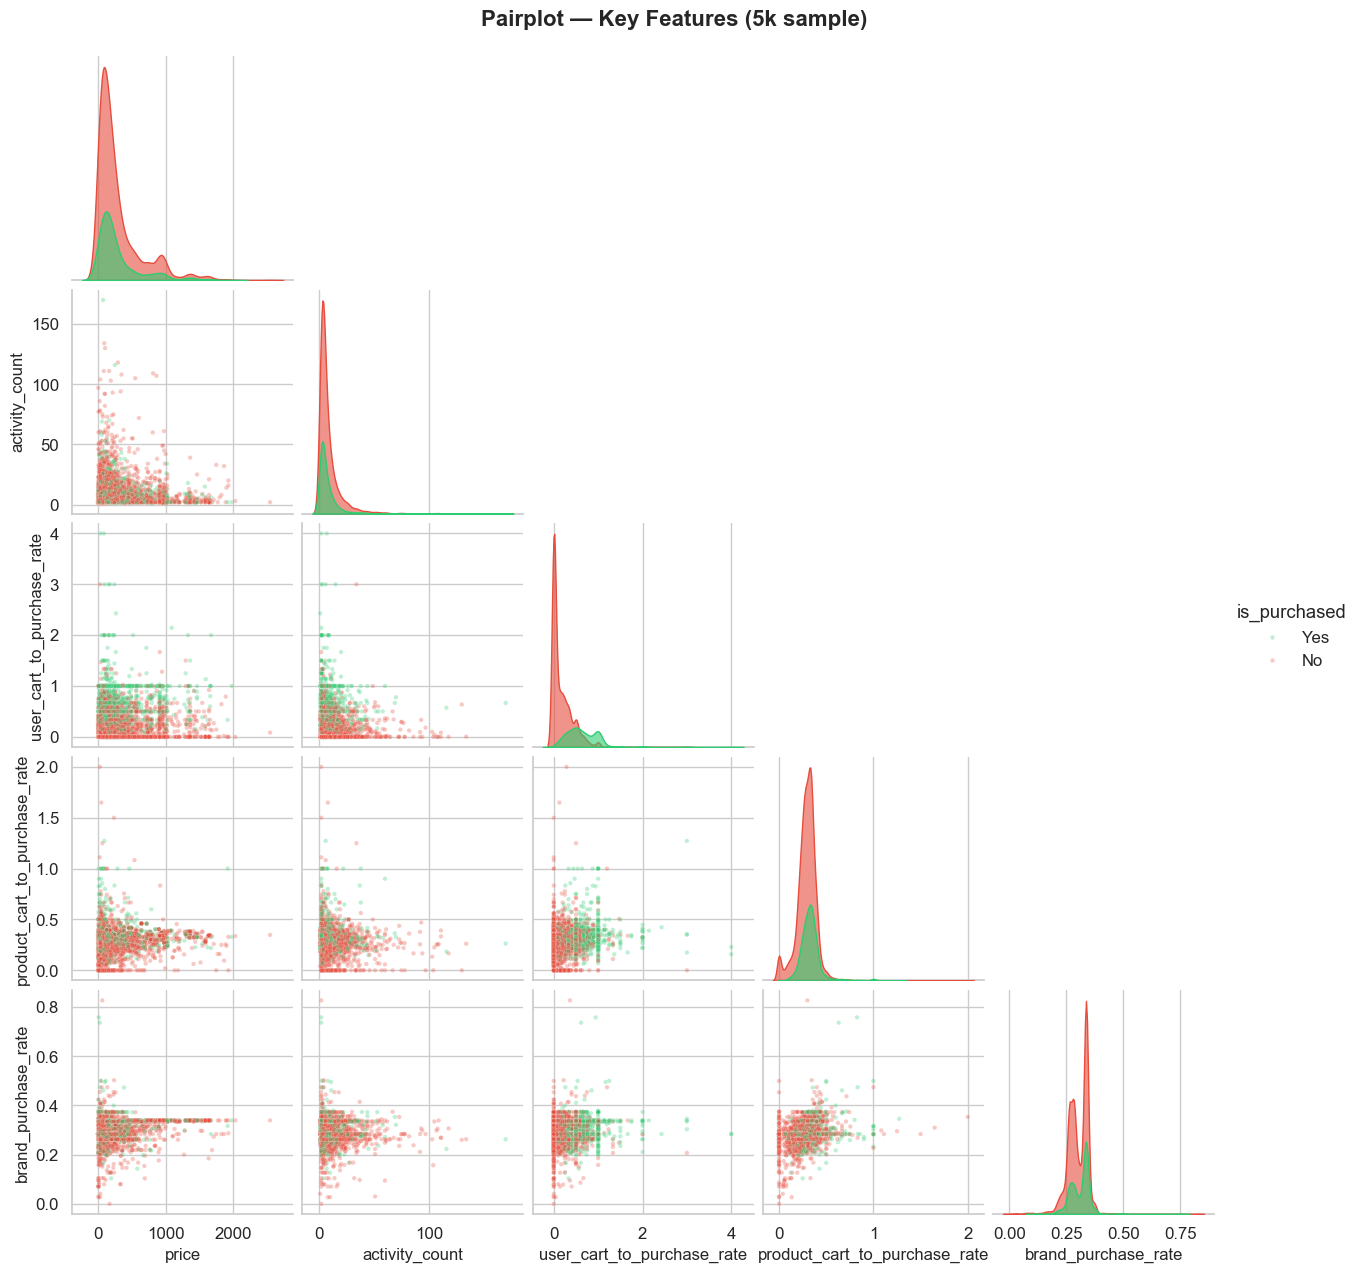

In [38]:
key_features = [
    "price", "activity_count",
    "user_cart_to_purchase_rate", "product_cart_to_purchase_rate",
    "brand_purchase_rate", "is_purchased",
]

sample = df[key_features].sample(n=5000, random_state=42)
sample["is_purchased"] = sample["is_purchased"].map({0: "No", 1: "Yes"})

g = sns.pairplot(
    sample,
    hue="is_purchased",
    palette={"No": "#e74c3c", "Yes": "#2ecc71"},
    diag_kind="kde",
    plot_kws={"alpha": 0.3, "s": 10},
    diag_kws={"alpha": 0.6},
    corner=True,
)
g.figure.suptitle("Pairplot — Key Features (5k sample)", fontsize=16, fontweight="bold", y=1.02)
plt.show()

### 5.4 User vs Product Conversion Rate

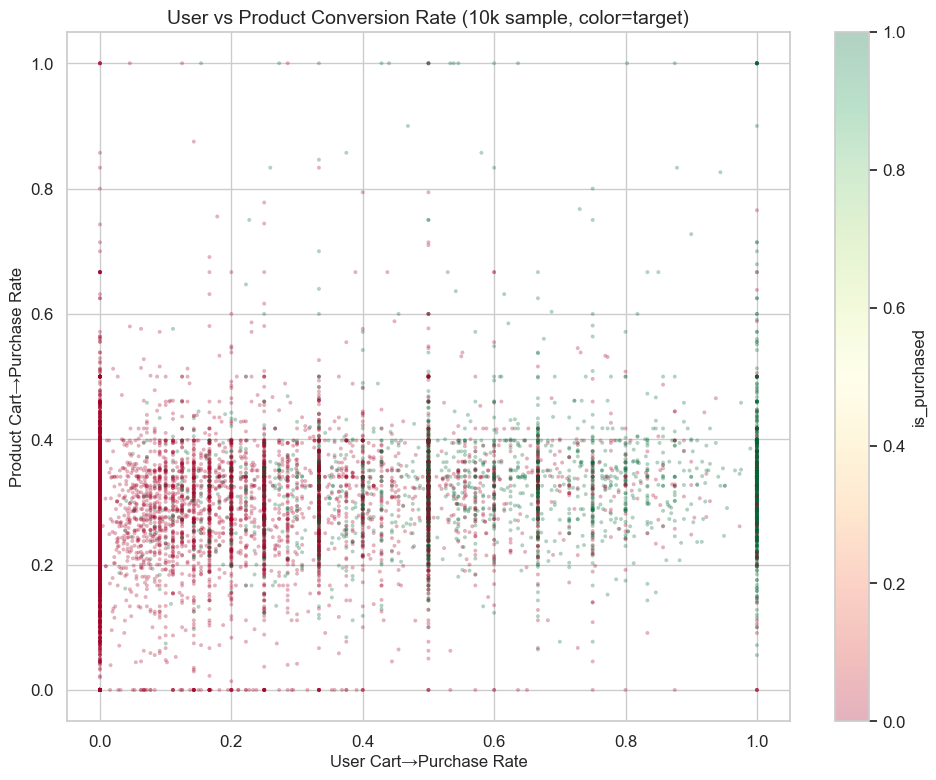

In [39]:
sample_scatter = df.sample(n=10000, random_state=42)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    sample_scatter["user_cart_to_purchase_rate"].clip(upper=1.0),
    sample_scatter["product_cart_to_purchase_rate"].clip(upper=1.0),
    c=sample_scatter["is_purchased"],
    cmap="RdYlGn",
    alpha=0.3,
    s=8,
    edgecolors="none",
)
ax.set_xlabel("User Cart→Purchase Rate")
ax.set_ylabel("Product Cart→Purchase Rate")
ax.set_title("User vs Product Conversion Rate (10k sample, color=target)")
plt.colorbar(scatter, label="is_purchased", ax=ax)
plt.tight_layout()
plt.show()

### 5.5 Price vs Activity Count

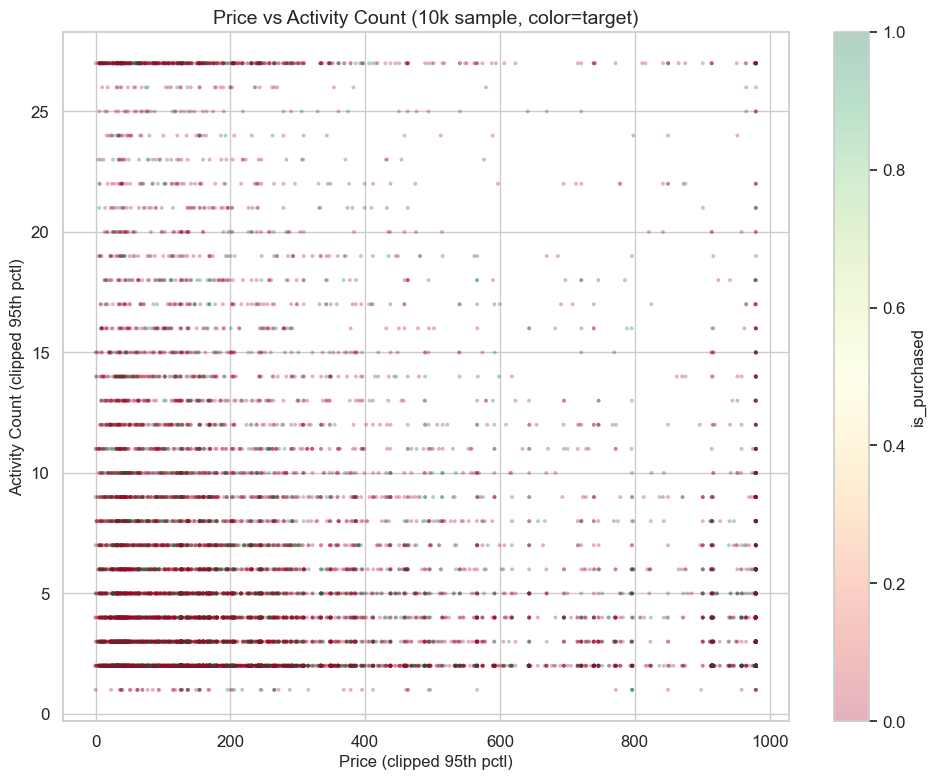

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    sample_scatter["price"].clip(upper=sample_scatter["price"].quantile(0.95)),
    sample_scatter["activity_count"].clip(upper=sample_scatter["activity_count"].quantile(0.95)),
    c=sample_scatter["is_purchased"],
    cmap="RdYlGn",
    alpha=0.3,
    s=8,
    edgecolors="none",
)
ax.set_xlabel("Price (clipped 95th pctl)")
ax.set_ylabel("Activity Count (clipped 95th pctl)")
ax.set_title("Price vs Activity Count (10k sample, color=target)")
plt.colorbar(scatter, label="is_purchased", ax=ax)
plt.tight_layout()
plt.show()

---
# Phase 6: Feature Engineering Insights

### 6.1 Average User Funnel

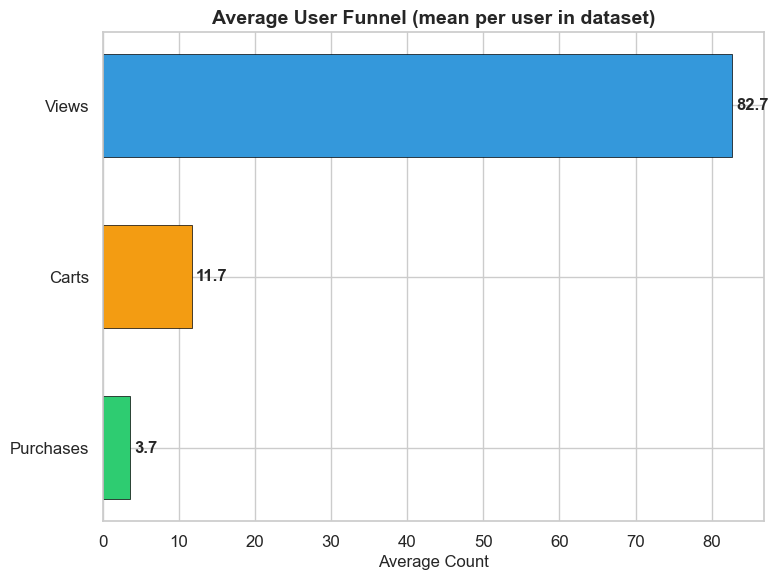

View→Cart conversion: 14.2%
Cart→Purchase conversion: 31.3%
Overall View→Purchase: 4.4%


In [41]:
funnel_data = {
    "Views": df["user_total_views"].mean(),
    "Carts": df["user_total_carts"].mean(),
    "Purchases": df["user_total_purchases"].mean(),
}

fig, ax = plt.subplots(figsize=(8, 6))
stages = list(funnel_data.keys())
values = list(funnel_data.values())
colors_funnel = ["#3498db", "#f39c12", "#2ecc71"]

bars = ax.barh(stages[::-1], values[::-1], color=colors_funnel[::-1], edgecolor="black", linewidth=0.5, height=0.6)
for bar, val in zip(bars, values[::-1]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}", va="center", fontsize=12, fontweight="bold")

ax.set_title("Average User Funnel (mean per user in dataset)", fontsize=14, fontweight="bold")
ax.set_xlabel("Average Count")
plt.tight_layout()
plt.show()

print(f"View→Cart conversion: {funnel_data['Carts'] / funnel_data['Views'] * 100:.1f}%")
print(f"Cart→Purchase conversion: {funnel_data['Purchases'] / funnel_data['Carts'] * 100:.1f}%")
print(f"Overall View→Purchase: {funnel_data['Purchases'] / funnel_data['Views'] * 100:.1f}%")

### 6.2 Average Product Funnel

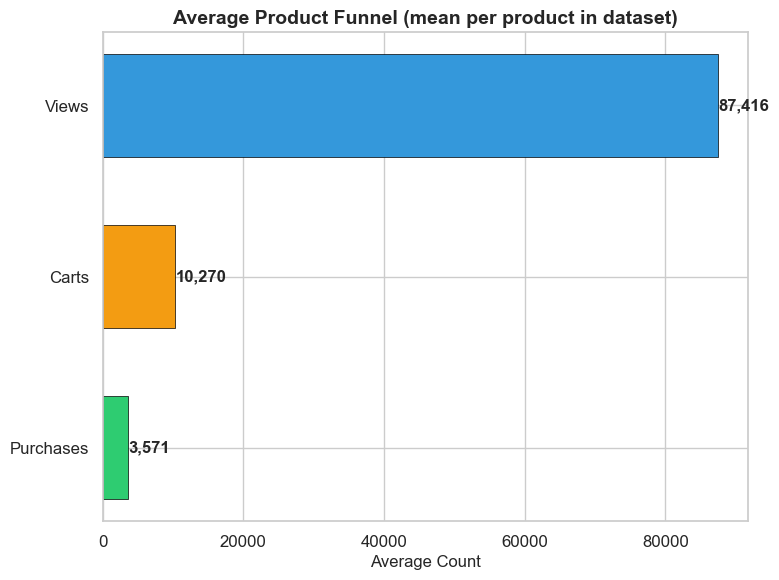

In [42]:
product_funnel = {
    "Views": df["product_total_views"].mean(),
    "Carts": df["product_total_carts"].mean(),
    "Purchases": df["product_total_purchases"].mean(),
}

fig, ax = plt.subplots(figsize=(8, 6))
stages = list(product_funnel.keys())
values = list(product_funnel.values())

bars = ax.barh(stages[::-1], values[::-1], color=colors_funnel[::-1], edgecolor="black", linewidth=0.5, height=0.6)
for bar, val in zip(bars, values[::-1]):
    ax.text(bar.get_width() + 100, bar.get_y() + bar.get_height() / 2,
            f"{val:,.0f}", va="center", fontsize=12, fontweight="bold")

ax.set_title("Average Product Funnel (mean per product in dataset)", fontsize=14, fontweight="bold")
ax.set_xlabel("Average Count")
plt.tight_layout()
plt.show()

### 6.3 Mean Feature Values: Purchased vs Not Purchased

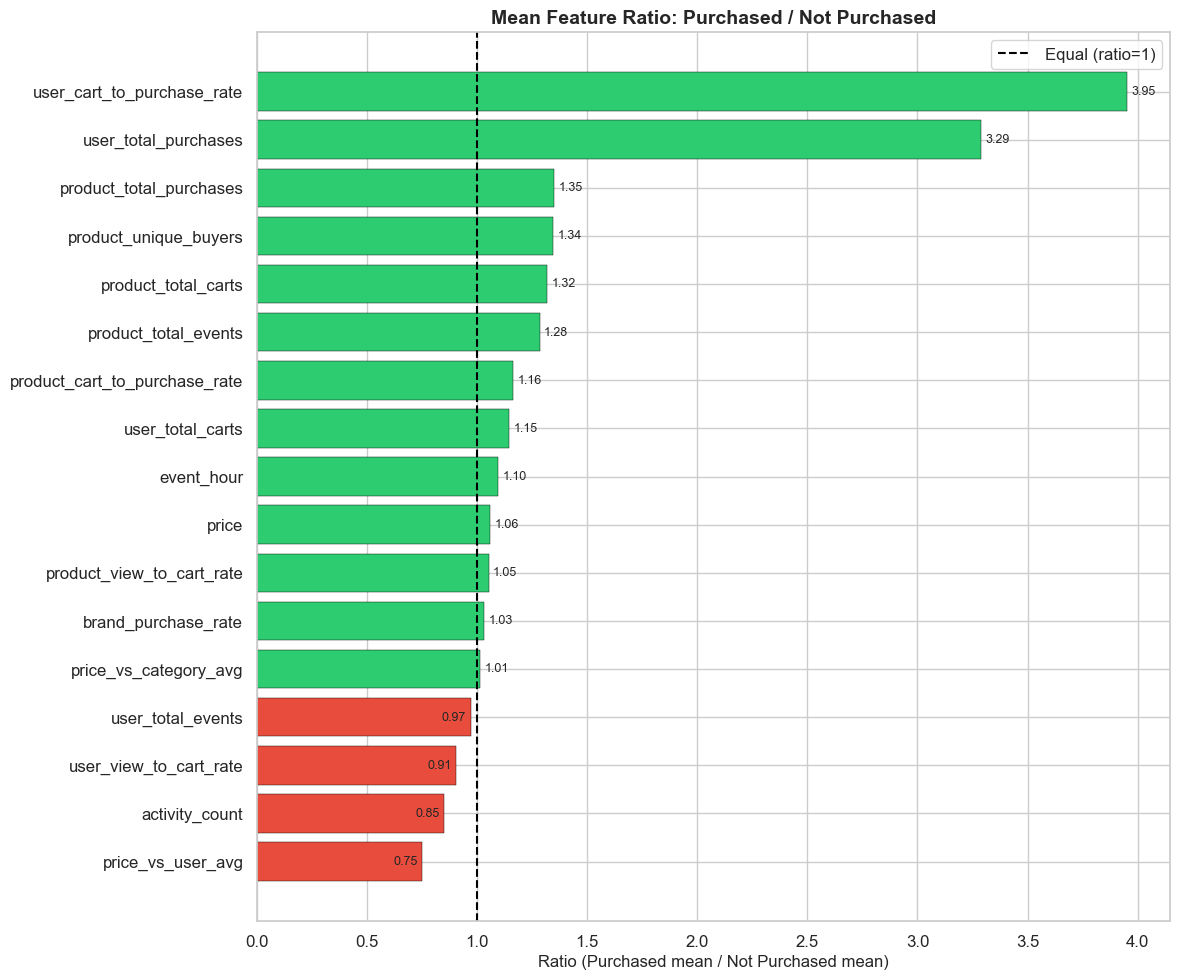

In [43]:
compare_features = [
    "price", "activity_count", "event_hour",
    "user_total_events", "user_total_carts", "user_total_purchases",
    "user_view_to_cart_rate", "user_cart_to_purchase_rate",
    "product_total_events", "product_total_carts", "product_total_purchases",
    "product_view_to_cart_rate", "product_cart_to_purchase_rate",
    "product_unique_buyers", "brand_purchase_rate",
    "price_vs_user_avg", "price_vs_category_avg",
]

means = df.groupby("is_purchased")[compare_features].mean()
ratio = (means.loc[1] / means.loc[0]).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
colors = ["#2ecc71" if v > 1 else "#e74c3c" for v in ratio.values]
bars = ax.barh(ratio.index, ratio.values, color=colors, edgecolor="black", linewidth=0.3)
ax.axvline(1.0, color="black", linewidth=1.5, linestyle="--", label="Equal (ratio=1)")
ax.set_title("Mean Feature Ratio: Purchased / Not Purchased", fontsize=14, fontweight="bold")
ax.set_xlabel("Ratio (Purchased mean / Not Purchased mean)")
ax.legend()

for bar, val in zip(bars, ratio.values):
    x_pos = val + 0.02 if val >= 1 else val - 0.02
    ax.text(x_pos, bar.get_y() + bar.get_height() / 2, f"{val:.2f}",
            va="center", ha="left" if val >= 1 else "right", fontsize=9)

plt.tight_layout()
plt.show()

### 6.4 Category × Brand Heatmap (Top 10 each, purchase rate)

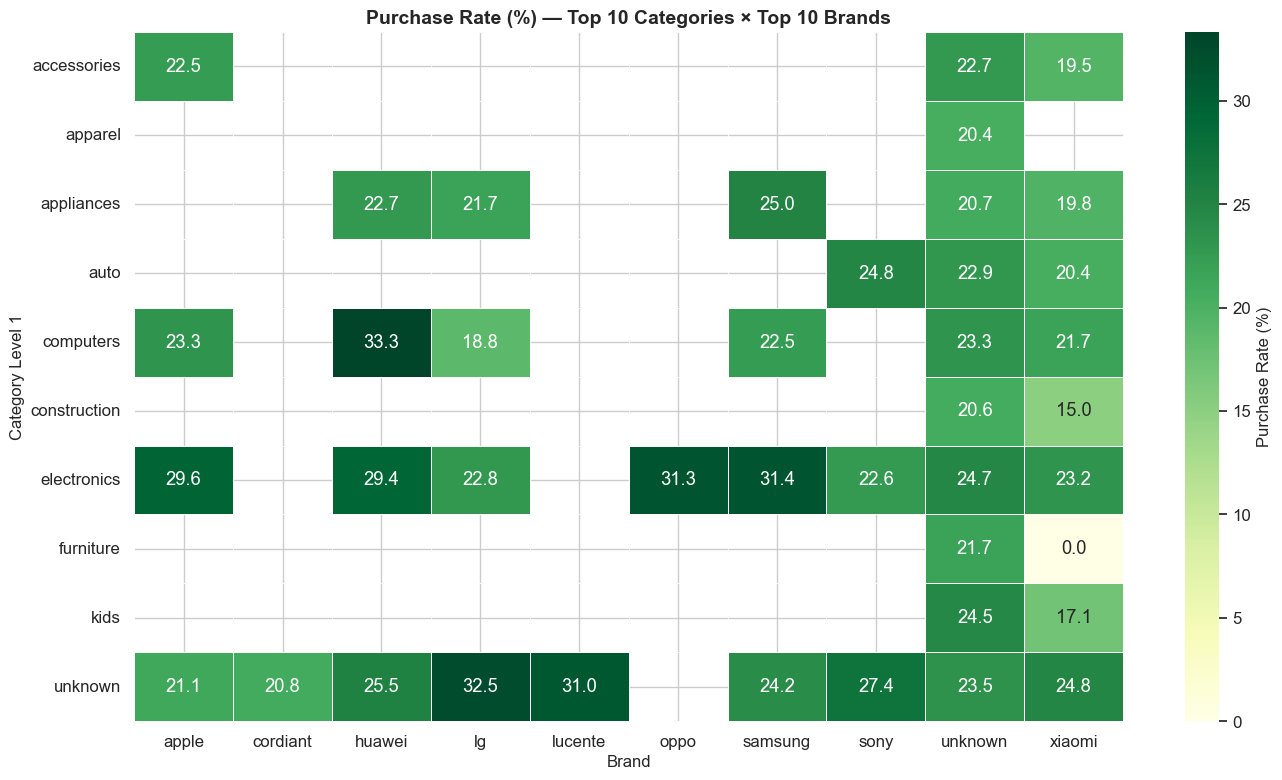

In [44]:
top10_cat = df["category_code_level1"].value_counts().head(10).index.tolist()
top10_brand = df["brand"].value_counts().head(10).index.tolist()

subset = df[df["category_code_level1"].isin(top10_cat) & df["brand"].isin(top10_brand)]
pivot = subset.pivot_table(
    index="category_code_level1",
    columns="brand",
    values="is_purchased",
    aggfunc="mean",
)

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    pivot * 100,
    annot=True,
    fmt=".1f",
    cmap="YlGn",
    linewidths=0.5,
    ax=ax,
    cbar_kws={"label": "Purchase Rate (%)"},
)
ax.set_title("Purchase Rate (%) — Top 10 Categories × Top 10 Brands", fontsize=14, fontweight="bold")
ax.set_xlabel("Brand")
ax.set_ylabel("Category Level 1")
plt.tight_layout()
plt.show()

---
# Phase 7: Advanced Analysis

### 7.1 Feature Distribution Overlap (KDE by class)

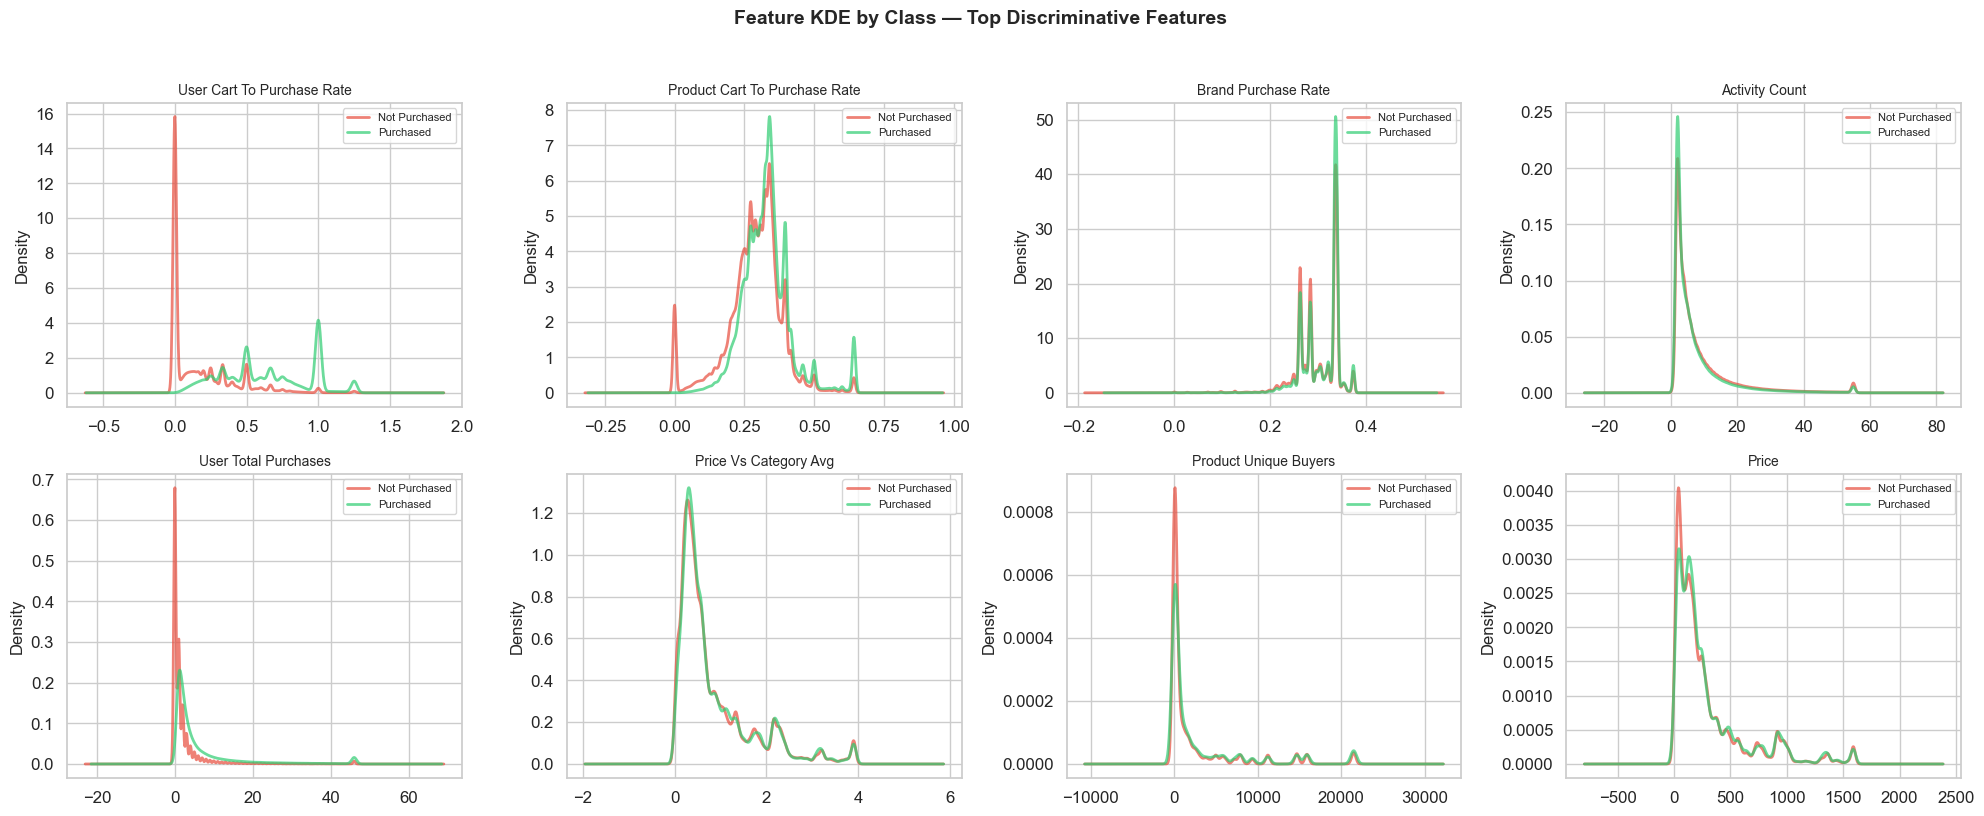

In [45]:
top_features = [
    "user_cart_to_purchase_rate", "product_cart_to_purchase_rate",
    "brand_purchase_rate", "activity_count",
    "user_total_purchases", "price_vs_category_avg",
    "product_unique_buyers", "price",
]

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for ax, col in zip(axes.flatten(), top_features):
    clipped = df[col].clip(upper=df[col].quantile(0.99))
    for label, color, name in [(0, "#e74c3c", "Not Purchased"), (1, "#2ecc71", "Purchased")]:
        subset = clipped[df["is_purchased"] == label]
        subset.plot.kde(ax=ax, color=color, label=name, alpha=0.7, linewidth=2)
    ax.set_title(col.replace("_", " ").title(), fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xlabel("")

plt.suptitle("Feature KDE by Class — Top Discriminative Features", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### 7.2 Hour × Weekday Heatmap (Purchase Rate)

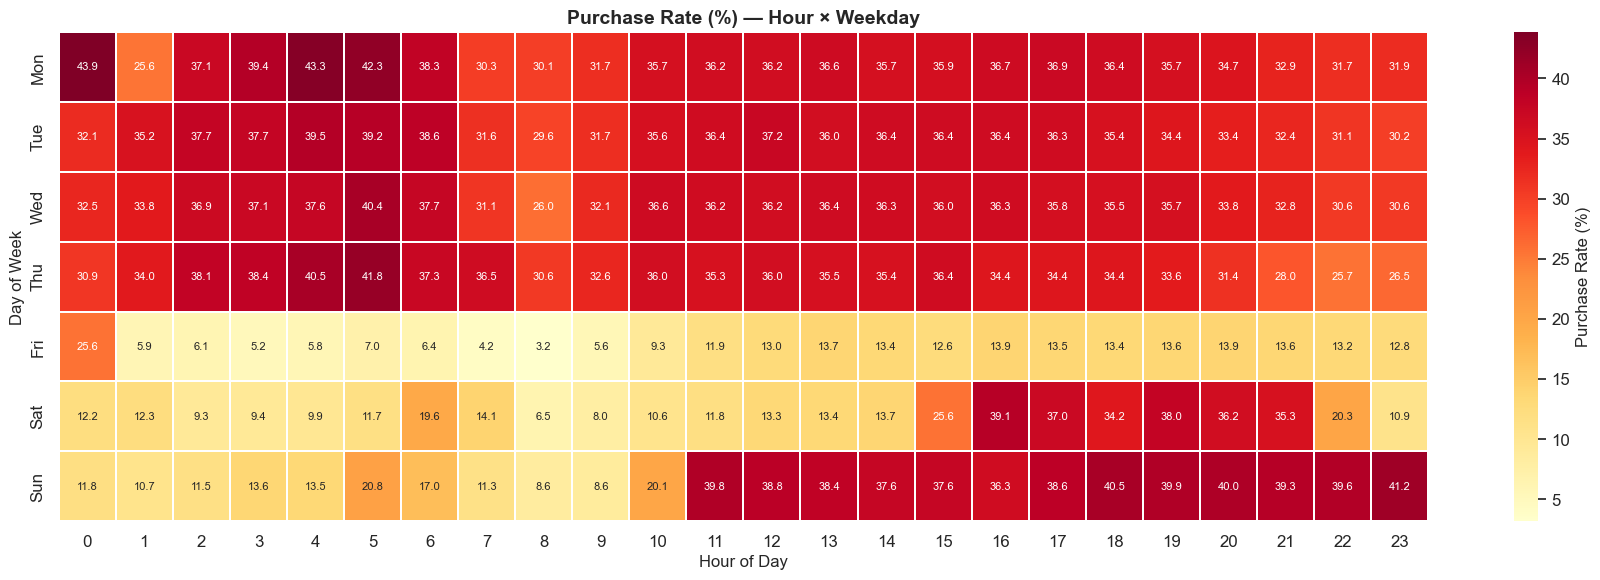

In [46]:
pivot_hw = df.pivot_table(
    index="event_weekday",
    columns="event_hour",
    values="is_purchased",
    aggfunc="mean",
)

weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(
    pivot_hw * 100,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    linewidths=0.3,
    ax=ax,
    yticklabels=[weekday_labels[i] for i in pivot_hw.index],
    cbar_kws={"label": "Purchase Rate (%)"},
    annot_kws={"size": 8},
)
ax.set_title("Purchase Rate (%) — Hour × Weekday", fontsize=14, fontweight="bold")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day of Week")
plt.tight_layout()
plt.show()

# **Summary & Key Findings**

## 1. Target Distribution
- **Class imbalance**: 74.07% Not Purchased / 25.93% Purchased
- **Imbalance ratio**: 1:2.86 (negative:positive)
- **Implication**: Cần xử lý imbalance, có thể dùng `scale_pos_weight` hoặc oversampling

## 2. Key Observations

### 2.1 Temporal Patterns
- **Peak hour**: 19h (32.3% purchase rate) — khung giờ sau giờ làm việc
- **Lowest hour**: 8h (10.3% purchase rate) — sáng sớm ít convert nhất
- **Weekday pattern**: 
  - Mon-Tue-Wed: cao (~34-36%)
  - Thu: 33.1%
  - **Fri**: đặc biệt thấp (11.7%) dù volume cao nhất (730k events) → cần investigate thêm
  - Sat: 21.5%
  - Sun: 33.7%

### 2.2 Category Insights
- **Top converting categories** (by purchase rate):
  - electronics: 28.87% (n=1.47M — largest volume)
  - computers: 24.18%
  - kids: 23.99%
  - appliances: 23.73%
- **Insight**: electronics chiếm 50% volume và có rate cao nhất

### 2.3 Brand Insights
- **Top converting brands** (trong top 20 by volume):
  - oppo: 31.35%
  - lucente: 31.03%
  - samsung: 30.69%
  - apple: 29.48%
- **Insight**: Samsung & Apple top volume nhưng không phải top conversion

### 2.4 User Behavior (CRITICAL!)
| Feature | Not Purchased (median) | Purchased (median) | Gap |
|---------|----------------------|-------------------|-----|
| user_cart_to_purchase_rate | 0.044 | 0.600 | **13.6x** |
| user_view_to_cart_rate | 0.145 | 0.200 | 1.4x |
| activity_count | 5 | 4 | -20% |

- **user_cart_to_purchase_rate** là feature mạnh nhất (corr = 0.602)
- User mua có xu hướng ít hoạt động hơn nhưng tỷ lệ convert từ cart→purchase cao hơn nhiều

### 2.5 Price Sensitivity
- Purchased: median=172.12, mean=303.34
- Not Purchased: median=166.80, mean=285.87
- **Insight**: Người mua có giá trung bình cao hơn ~6% — không quá khác biệt

## 3. Feature Importance Preview (Correlation with Target)

### Top Positive Correlations:
1. `user_cart_to_purchase_rate`: **0.602** (strongest)
2. `user_avg_purchase_price`: 0.259
3. `user_total_purchases`: 0.187
4. `product_cart_to_purchase_rate`: 0.176
5. `brand_purchase_rate`: 0.094

### Negative Correlations:
- `event_weekday`: -0.069 (Fri effect)
- `activity_count`: -0.049
- `price_vs_user_avg`: -0.042

## 4. Multicollinearity Issues (|corr| > 0.9)

Các cặp sau chứa thông tin trùng lặp cao:

| Feature A | Feature B | Correlation |
|-----------|-----------|-------------|
| product_total_events | product_total_views | 0.999 |
| product_total_carts | product_total_purchases | 0.995 |
| product_total_carts | product_unique_buyers | 0.995 |
| product_total_views | product_total_carts | 0.976 |
| user_total_events | user_total_views | 0.977 |

**Action**: Chỉ giữ lại 1 feature đại diện cho mỗi cụm

## 5. Recommended Feature Selection

### Shortlist (~10 features):
1. `user_cart_to_purchase_rate` — strongest signal
2. `user_view_to_cart_rate` — complementary
3. `user_avg_purchase_price` — high correlation
4. `product_cart_to_purchase_rate` — product quality
5. `brand_purchase_rate` — brand strength
6. `category_code_level1` — categorical with good spread
7. `event_hour` — temporal signal
8. `event_weekday` — temporal signal
9. `price` — base feature
10. `activity_count` — engagement signal

### Exclude/Drop:
- `product_total_*` (giữ 1, drop 4 do multicollinearity)
- `user_total_*` events/views (giữ conversion rates, drop counts)
- Features có correlation < 0.01 với target (user_unique_*, some counts)

## 6. Potential Issues

### Data Quality
- **Friday anomaly**: 11.7% rate vs ~34% các ngày khác → kiểm tra data collection hoặc có sự kiện
- **Category imbalance**: electronics chiếm 50% data

### Leakage Risk
- `user_total_purchases` — có thể chứa future information nếu user mua sau thời điểm quan sát
- `product_total_purchases` — tương tự


